This notebook addresses multivariate analysis for data published in [Helmke and Heald, 2014](http://jcb.rupress.org/content/206/3/385.full). All images were passed through the pipeline reported here. In this notebook, we have focused on demonstrating, how one can quickly pick most interesting variables from a multivariate data set. To run the notebook with your own input, just substitute the respective paths.

####Table of contents:   
1. Data folder.     
2. Feature description and pre-processing  
    * meta data, object location, missing values
3. Feature selection and engineering    
4. Predictive models    
5. Unsupervised models    



Non-standard columns: **'Meta'** columns, **'locator'** columns, **'NA'** columns, **Euclidian distance** (engineered), **Zernike polynomials**, **children**, **parents**. 

#I. Data folder

In [1]:
!ls ../../A_PAPER2_PIPELINE

Colors.txt                     STG8
Complete Dataset               STG8_CSF_Mixing
Partial Datasets               TPX2
Presentation:Figures:etc       TPX2_feature_selection.numbers


In [2]:
!ls ../../A_PAPER2_PIPELINE/TPX2/ 

DefaultDB.db
DefaultDB_MyExpt.properties
DefaultOUT.h5
MyExpt_Chromatin.csv
MyExpt_Experiment.csv
MyExpt_FilteredChromatin.csv
MyExpt_FilteredSpindles.csv
MyExpt_Image.csv
MyExpt_PreSpindles.csv
MyExpt_Spindles.csv
TPX2_df_cont_no_Y_trans_no_null_var_PCA.csv


In [3]:
!head -n3 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_Chromatin.csv 

The file above specifies the location of objects.

In [4]:
!head ../../A_PAPER2_PIPELINE/TPX2/MyExpt_Experiment.csv 







Pipeline_Pipeline,"CellProfiler Pipeline: http://www.cellprofiler.org
Version:3
DateRevision:20140723173957
GitHash:6c2d896


In [5]:
!head -n2 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_FilteredChromatin.csv

The file below is the actual file of interest.

In [6]:
!head ../../A_PAPER2_PIPELINE/TPX2/MyExpt_FilteredSpindles.csv

It has 203 columns, though not all of them are actual measurements.

In [7]:
!head -n3 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_FilteredSpindles.csv | awk 'BEGIN{FS=","}{print NF}'

203
203
203


In [8]:
!head -n2 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_Image.csv

In [9]:
!head -n 2 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_Image.csv | awk 'BEGIN{FS=","} {print NF}' 

1012
1012


In [10]:
!head -n2 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_PreSpindles.csv

In [11]:
!head -n2 ../../A_PAPER2_PIPELINE/TPX2/MyExpt_Spindles.csv

#II. Feature description and pre-processing    
Important things to consider:   
- missing data    
- types of variables (classes)    
- types of distributions (moments of distribution) and necessary transformations (Box-Cox)
- collinearity and multicollinearity (PCA, VIF, )

#Preliminary feature selection and engineering
There are several ways to select best features. One thing that one has to take into consideration is a phenomenon called multicollinearity, in which we have near linear relationships in explanatory variables, which leads to unstable parameter estimates. It may not necessarily affect accuracy of a predictive model, but it will affect analysis of the features that contribute to its performance (we will compare that). We would like to identify these variables, as, scientifically, we might actually be interested in these correlations (although some may be a result of mathematical necessity). The added benefit is that, once we know them, we can take care of them before we run a classification algorithm.      
       
Some of the options one can consider: 
* removing features with lowest variance     
* performing feature selection based on the value of variance inflation factor (for regression)   
* factor analysis (classification of variables)
* selecting variables based on weights in classification model(LASSO)
* univariate feature selection: Kruskall-Wallis / KS / Fischer / t-test
* stepwise discriminant analysis
* sequential forward search (SFS)
* sequential floating forward search (SFFS)
* classifier supported recursive feature elimination 
* recursive feature elimination
* genetic algorithms
* simulated annealing
* binary recursive tree models



##IIa. Variable types and missing values

**First**, we load all necessary packages.

In [12]:
%load_ext rpy2.ipython
%matplotlib inline

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
pd.set_option('display.mpl_style','default')
from matplotlib.backends.backend_pdf import PdfPages

import sklearn

**Second**, we load the data.

In [14]:
df=pd.read_csv('../../A_PAPER2_PIPELINE/TPX2/MyExpt_FilteredSpindles.csv')
meta=pd.read_table('../Data/columns_meta.txt',header=None,names=['meta_columns'])


In [15]:
df.Metadata_Treatment.unique()

array([  0, 302])

In [16]:
df_raw=pd.read_csv('../../A_PAPER2_PIPELINE/TPX2/MyExpt_FilteredSpindles.csv')

In [17]:
df_raw.groupby("Metadata_Treatment").count()

ImageNumber  ObjectNumber  Metadata_Experiment  \
Metadata_Treatment                                                   
0                          1935          1935                 1935   
302                        2621          2621                 2621   

                    Metadata_Experimenter  Metadata_FileLocation  \
Metadata_Treatment                                                 
0                                    1935                      0   
302                                  2621                      0   

                    Metadata_Frame  Metadata_Series  Metadata_Set  \
Metadata_Treatment                                                  
0                             1935             1935          1935   
302                           2621             2621          2621   

                    Metadata_Type  Metadata_cvsp       ...         \
Metadata_Treatment                                     ...          
0                            1935           1935       ...          
302                          2621           2621       ...          

                    Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine  \
Metadata_Treatment                                                                    
0                                                                1935                 
302                                                              2621                 

                    Mean_FilteredChromatin_Location_Center_X  \
Metadata_Treatment                                             
0                                                       1935   
302                                                     2621   

                    Mean_FilteredChromatin_Location_Center_Y  \
Metadata_Treatment                                             
0                                                       1935   
302                                                     2621   

                    Mean_FilteredChromatin_Location_MaxIntensity_X_DNA  \
Metadata_Treatment                                                       
0                                                                1935    
302                                                              2621    

                    Mean_FilteredChromatin_Location_MaxIntensity_X_Rhodamine  \
Metadata_Treatment                                                             
0                                                                1935          
302                                                              2621          

                    Mean_FilteredChromatin_Location_MaxIntensity_Y_DNA  \
Metadata_Treatment                                                       
0                                                                1935    
302                                                              2621    

                    Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine  \
Metadata_Treatment                                                             
0                                                                1935          
302                                                              2621          

                    Mean_FilteredChromatin_Number_Object_Number  \
Metadata_Treatment                                                
0                                                          1935   
302                                                        2621   

                    Number_Object_Number  Parent_Spindles  
Metadata_Treatment                                         
0                                   1935             1935  
302                                 2621             2621  

[2 rows x 202 columns]

In [18]:
object_locators = pd.read_table('../Data/columns_obj_locators_ext.txt',header=None,names=['loc_columns'])

In [19]:
df.head()

ImageNumber  ObjectNumber Metadata_Experiment Metadata_Experimenter  \
0            1             1               Exp27                   KHR   
1            2             1               Exp27                   KHR   
2            2             2               Exp27                   KHR   
3            2             3               Exp27                   KHR   
4            2             4               Exp27                   KHR   

   Metadata_FileLocation  Metadata_Frame  Metadata_Series Metadata_Set  \
0                    NaN               0                0      cvsp1_0   
1                    NaN               0                0      cvsp1_1   
2                    NaN               0                0      cvsp1_1   
3                    NaN               0                0      cvsp1_1   
4                    NaN               0                0      cvsp1_1   

   Metadata_Treatment Metadata_Type       ...         \
0                   0           CYC       ...          
1                   0           CYC       ...          
2                   0           CYC       ...          
3                   0           CYC       ...          
4                   0           CYC       ...          

   Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine  \
0                                         613.284456                 
1                                         218.278124                 
2                                         316.177551                 
3                                         532.178965                 
4                                         925.178158                 

   Mean_FilteredChromatin_Location_Center_X  \
0                                775.805433   
1                                506.870355   
2                                914.427921   
3                                843.116935   
4                                387.579022   

   Mean_FilteredChromatin_Location_Center_Y  \
0                                614.289800   
1                                231.685745   
2                                304.759385   
3                                530.702649   
4                                935.141738   

   Mean_FilteredChromatin_Location_MaxIntensity_X_DNA  \
0                                                736    
1                                                508    
2                                                900    
3                                                844    
4                                                395    

   Mean_FilteredChromatin_Location_MaxIntensity_X_Rhodamine  \
0                                                773          
1                                                506          
2                                                932          
3                                                884          
4                                                409          

   Mean_FilteredChromatin_Location_MaxIntensity_Y_DNA  \
0                                                597    
1                                                221    
2                                                347    
3                                                505    
4                                                947    

   Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine  \
0                                                595          
1                                                204          
2                                                338          
3                                                503          
4                                                903          

   Mean_FilteredChromatin_Number_Object_Number  Number_Object_Number  \
0                                            1                     1   
1                                            1                     1   
2                                            2                     2   
3                                            3           

In [20]:
len(df.columns)

203

The file below was used to seed Table S1.

In [21]:
'''
import sys

col_file=open('../Data/columns.txt','wb')

for col in df.columns:
    col_file.write(col+'\n')
    sys.stdout.write(col+'\n')
col_file.close()
'''

"\nimport sys\n\ncol_file=open('../Data/columns.txt','wb')\n\nfor col in df.columns:\n    col_file.write(col+'\n')\n    sys.stdout.write(col+'\n')\ncol_file.close()\n"

There are 203 columns (variables) in the Cell Profiler output data frame. However, not all of them are relevant 

**Third**, we check for any **missing values**.

In [22]:
np.sum(df.isnull())

ImageNumber                                                             0
ObjectNumber                                                            0
Metadata_Experiment                                                     0
Metadata_Experimenter                                                   0
Metadata_FileLocation                                                4556
Metadata_Frame                                                          0
Metadata_Series                                                         0
Metadata_Set                                                            0
Metadata_Treatment                                                      0
Metadata_Type                                                           0
Metadata_cvsp                                                           0
AreaShape_Area                                                          0
AreaShape_Center_X                                                      0
AreaShape_Center_Y                    

In [23]:
np.sum(df.isnull())[np.sum(df.isnull())!=0]

Metadata_FileLocation                                        4556
Mean_FilteredChromatin_Distance_Centroid_FilteredSpindles    4556
Mean_FilteredChromatin_Distance_Minimum_FilteredSpindles     4556
dtype: int64

In [24]:
NAs=list(np.sum(df.isnull())[np.sum(df.isnull())!=0].index)

In [25]:
df[np.sum(df.isnull())[np.sum(df.isnull())!=0].index].head()

Metadata_FileLocation  \
0                    NaN   
1                    NaN   
2                    NaN   
3                    NaN   
4                    NaN   

   Mean_FilteredChromatin_Distance_Centroid_FilteredSpindles  \
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           

   Mean_FilteredChromatin_Distance_Minimum_FilteredSpindles  
0                                                NaN         
1                                                NaN         
2                                                NaN         
3                                                NaN         
4                                                NaN

We can also nicely visualize the missing values by plotting data as a matrix.

In [26]:
def visualizeNaNs(data_frame, row_names='Examples', column_names='Variables',title="NaN's"):
    #data_frame_to_plt=data_frame.drop(list(df.dtypes[df.dtypes=='object'].index),axis=1)
    data_frame_to_plt=data_frame.isnull()
    
    plt.imshow(data_frame_to_plt.get_values(),aspect='auto',cmap='binary')
    plt.xlabel(column_names) #, verticalalignment ='top'
    plt.ylabel(row_names)
    plt.title(title)
    plt.colorbar()

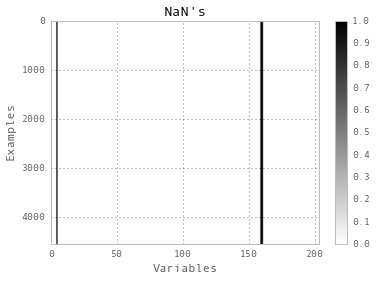

In [27]:
visualizeNaNs(df)

If we wanted to mark the columns with strings (words), we need to slightly modify the code.

In [28]:
df[list(df.dtypes[df.dtypes=='object'].index)].head()

Metadata_Experiment Metadata_Experimenter Metadata_Set Metadata_Type
0               Exp27                   KHR      cvsp1_0           CYC
1               Exp27                   KHR      cvsp1_1           CYC
2               Exp27                   KHR      cvsp1_1           CYC
3               Exp27                   KHR      cvsp1_1           CYC
4               Exp27                   KHR      cvsp1_1           CYC

In [29]:
def visualizeNaNs_and_strings(data_frame, row_names='Examples', column_names='Variables',title="NaN's and Strings"):
    #data_frame_to_plt=data_frame.drop(list(df.dtypes[df.dtypes=='object'].index),axis=1)
    data_frame_to_plt=data_frame.copy()
    data_frame_to_plt.loc[:,tuple(df.dtypes[df.dtypes=='object'].index)]=np.nan
    data_frame_to_plt=data_frame_to_plt.isnull()
    plt.imshow(data_frame_to_plt.get_values(),aspect='auto',cmap='binary')
    plt.xlabel(column_names) #, verticalalignment ='top'
    plt.ylabel(row_names)
    plt.title(title)
    plt.colorbar()

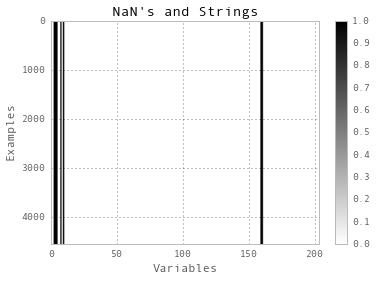

In [30]:
visualizeNaNs_and_strings(df)

So, there are three columns with NaN's and four columns with string variables. One of the string variables is a target variable for classifier.

In [31]:
df.shape

(4556, 203)

In [32]:
list(df.dtypes[df.dtypes=='object'].index)

['Metadata_Experiment',
 'Metadata_Experimenter',
 'Metadata_Set',
 'Metadata_Type']

In [33]:
df_no_string=df.drop(list(df.dtypes[df.dtypes=='object'].index),axis=1)

In [34]:
df_no_string.shape

(4556, 199)

**Fourth**, we'll get all metadata columns. We can, of course use all the string data from above.

In [35]:
meta_data=[]
for col_name in df.columns:
    if re.match(r'.*(data).*', col_name) != None:
        meta_data.append(re.match(r'.*(data).*', col_name).group(0))

In [36]:
meta_data

['Metadata_Experiment',
 'Metadata_Experimenter',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_Set',
 'Metadata_Treatment',
 'Metadata_Type',
 'Metadata_cvsp']

In [37]:
[df.columns.tolist().index(col_meta) for col_meta in meta_data]

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [38]:
first_cols=df.columns.tolist()[0:2]

In [39]:
first_cols.reverse()

In [40]:
first_cols

['ObjectNumber', 'ImageNumber']

In [41]:
[meta_data.insert(0,col) for col in first_cols]

[None, None]

In [42]:
meta_data

['ImageNumber',
 'ObjectNumber',
 'Metadata_Experiment',
 'Metadata_Experimenter',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_Set',
 'Metadata_Treatment',
 'Metadata_Type',
 'Metadata_cvsp']

In [43]:
'''
import sys

col_file=open('../Data/columns_meta.txt','wb')

for col in meta_data:
    col_file.write(col+'\n')
    sys.stdout.write(col+'\n')
col_file.close()
'''

"\nimport sys\n\ncol_file=open('../Data/columns_meta.txt','wb')\n\nfor col in meta_data:\n    col_file.write(col+'\n')\n    sys.stdout.write(col+'\n')\ncol_file.close()\n"

The first two columns are also metadata. What about index 11 (12th column)?

In [44]:
len(meta_data)

11

In [45]:
df.columns[11], df.columns[12]

('AreaShape_Area', 'AreaShape_Center_X')

Looks like data column. However, these are columns that are  potentially irrelevant (unless you would like to look for **object location** biases). These are locators for objects detected within the image.

In [46]:
obj_locators=[]
obj_locators_ext=[]

for col in df.columns:
    if re.match('.*Center.*', col) !=None:
        obj_locators.append(re.match('.*Center.*', col).group())
    if re.match('.*Location.*', col) !=None:
        obj_locators_ext.append(re.match('.*Location.*', col).group())

In [47]:
obj_locators, obj_locators_ext

(['AreaShape_Center_X',
  'AreaShape_Center_Y',
  'Location_CenterMassIntensity_X_DNA',
  'Location_CenterMassIntensity_X_Rhodamine',
  'Location_CenterMassIntensity_Y_DNA',
  'Location_CenterMassIntensity_Y_Rhodamine',
  'Location_Center_X',
  'Location_Center_Y',
  'Mean_FilteredChromatin_AreaShape_Center_X',
  'Mean_FilteredChromatin_AreaShape_Center_Y',
  'Mean_FilteredChromatin_Location_CenterMassIntensity_X_DNA',
  'Mean_FilteredChromatin_Location_CenterMassIntensity_X_Rhodamine',
  'Mean_FilteredChromatin_Location_CenterMassIntensity_Y_DNA',
  'Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine',
  'Mean_FilteredChromatin_Location_Center_X',
  'Mean_FilteredChromatin_Location_Center_Y'],
 ['Metadata_FileLocation',
  'Location_CenterMassIntensity_X_DNA',
  'Location_CenterMassIntensity_X_Rhodamine',
  'Location_CenterMassIntensity_Y_DNA',
  'Location_CenterMassIntensity_Y_Rhodamine',
  'Location_Center_X',
  'Location_Center_Y',
  'Location_MaxIntensity_X_DNA',
  'Lo

In [48]:

df.Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine.head(), df.Location_CenterMassIntensity_Y_Rhodamine.head()

(0    595
 1    204
 2    338
 3    503
 4    903
 Name: Mean_FilteredChromatin_Location_MaxIntensity_Y_Rhodamine, dtype: float64,
 0    603.693973
 1    209.206649
 2    328.424317
 3    532.346492
 4    917.485153
 Name: Location_CenterMassIntensity_Y_Rhodamine, dtype: float64)

In [49]:
'''
import sys
col_file_1=open('../Data/columns_obj_locators.txt','wb')
col_file_2=open('../Data/columns_obj_locators_ext.txt','wb')


for col in obj_locators:
    col_file_1.write(col+'\n')
    sys.stdout.write(col+'\n')
col_file_1.close()
print
for col in obj_locators_ext:
    col_file_2.write(col+'\n')
    sys.stdout.write(col+'\n')
col_file_2.close()
'''


"\nimport sys\ncol_file_1=open('../Data/columns_obj_locators.txt','wb')\ncol_file_2=open('../Data/columns_obj_locators_ext.txt','wb')\n\n\nfor col in obj_locators:\n    col_file_1.write(col+'\n')\n    sys.stdout.write(col+'\n')\ncol_file_1.close()\nprint\nfor col in obj_locators_ext:\n    col_file_2.write(col+'\n')\n    sys.stdout.write(col+'\n')\ncol_file_2.close()\n"

In [50]:
len(set(obj_locators)), len(obj_locators_ext), len(set(obj_locators+obj_locators_ext))

(16, 21, 25)

In [51]:
obj_locators_ext_set=set(obj_locators+obj_locators_ext)
to_remove=[]
for term in obj_locators_ext_set:
    if re.match('^Meta.*',term)!=None:
        to_remove.append(re.match('^Meta.*',term).group(0))
        print to_remove

for term in to_remove:
    obj_locators_ext_set.remove(term)
len(obj_locators_ext_set)

['Metadata_FileLocation']


24

In [52]:
'''
import sys

col_file_1=open('../Data/columns_obj_locators_ext_set.txt','wb')

for col in obj_locators_ext_set:
    col_file_1.write(col+'\n')
    sys.stdout.write(col+'\n')
col_file_1.close()
'''

"\nimport sys\n\ncol_file_1=open('../Data/columns_obj_locators_ext_set.txt','wb')\n\nfor col in obj_locators_ext_set:\n    col_file_1.write(col+'\n')\n    sys.stdout.write(col+'\n')\ncol_file_1.close()\n"

In [53]:
[df.columns.tolist().index(loc) for loc in obj_locators]

[12, 13, 90, 91, 92, 93, 94, 95, 111, 112, 190, 191, 192, 193, 194, 195]

In [54]:
df[obj_locators].head()

AreaShape_Center_X  AreaShape_Center_Y  Location_CenterMassIntensity_X_DNA  \
0                 768                 612                          775.558323   
1                 509                 203                          504.332805   
2                 921                 329                          920.725186   
3                 866                 533                          852.325446   
4                 391                 912                          389.609310   

   Location_CenterMassIntensity_X_Rhodamine  \
0                                777.270489   
1                                504.743594   
2                                923.217718   
3                                853.617364   
4                                390.945494   

   Location_CenterMassIntensity_Y_DNA  \
0                          604.844882   
1                          210.513326   
2                          329.617368   
3                          532.886342   
4                          918.086935   

   Location_CenterMassIntensity_Y_Rhodamine  Location_Center_X  \
0                                603.693973         777.794638   
1                                209.206649         504.524979   
2                                328.424317         924.749786   
3                                532.346492         854.078808   
4                                917.485153         389.464582   

   Location_Center_Y  Mean_FilteredChromatin_AreaShape_Center_X  \
0         603.334184                                        742   
1         209.014137                                        505   
2         329.136027                                        906   
3         532.612807                                        842   
4         917.284890                                        391   

   Mean_FilteredChromatin_AreaShape_Center_Y  \
0                                        604   
1                                        225   
2                                        340   
3                                        520   
4                                        946   

   Mean_FilteredChromatin_Location_CenterMassIntensity_X_DNA  \
0                                         773.923290           
1                                         506.514375           
2                                         913.605789           
3                                         843.111078           
4                                         387.634171           

   Mean_FilteredChromatin_Location_CenterMassIntensity_X_Rhodamine  \
0                                         772.509043                 
1                                         504.636367                 
2                                         912.475064                 
3                                         845.119143                 
4                                         390.423672                 

   Mean_FilteredChromatin_Location_CenterMassIntensity_Y_DNA  \
0                                         613.369269           
1                                         231.096636           
2                                         307.644805           
3                                         529.461395           
4                                         936.092267           

   Mean_FilteredChromatin_Location_CenterMassIntensity_Y_Rhodamine  \
0                                         613.284456                 
1                                         218.278124                 
2                                         316.177551                 
3                                         532.178965                 
4                                         925.178158                 

   Mean_FilteredChromatin_Location_Center_X  \
0                                775.805433   
1                                506.870355   
2                                914.427921   
3                                843.116935   
4                                387.579022   

  

In [55]:
df.shape

(4556, 203)

Dropping object locators. We will use the extensively curated list.

In [56]:
df_no_centers=df.drop(obj_locators,axis=1) # in the corrected version, we will not use this one extensively

Worth considering: find **Euclidian distance** between the centers (Location_Center_X/Y and AreaShape_Center_X/Y) and use this as a variable.

In [57]:
df_no_centers.shape, df.shape

((4556, 187), (4556, 203))

In [58]:
def Euclidian_norm(x1,x2,y1,y2):
    a_sq=(np.abs(x1-x2))**2
    b_sq=(np.abs(y1-y2))**2
    c=np.sqrt(a_sq+b_sq)
    return c

In [59]:
Euclidian_norm(df.AreaShape_Center_X[0],df.Location_Center_X[0],df.AreaShape_Center_Y[0],df.Location_Center_Y[0])

13.077893451607723

In [60]:

df_no_centers['Euclidian_norm_centers']=Euclidian_norm(df.AreaShape_Center_X,df.Location_Center_X,df.AreaShape_Center_Y,df.Location_Center_Y)

In [61]:
df['Euclidian_norm_centers']=Euclidian_norm(df.AreaShape_Center_X,df.Location_Center_X,df.AreaShape_Center_Y,df.Location_Center_Y)

In [62]:
df.shape, df_no_centers.shape

((4556, 204), (4556, 188))

Test below for normality (incl. transformed one).

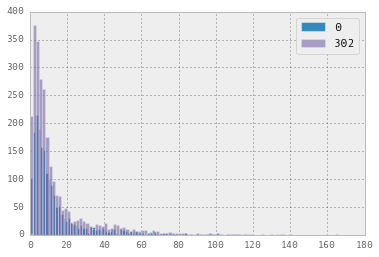

In [63]:
df_no_centers[df_no_centers.Metadata_Treatment==0].Euclidian_norm_centers.hist(bins=100)
df_no_centers[df_no_centers.Metadata_Treatment!=0].Euclidian_norm_centers.hist(bins=100, alpha=0.6)
plt.legend(('0','302'))

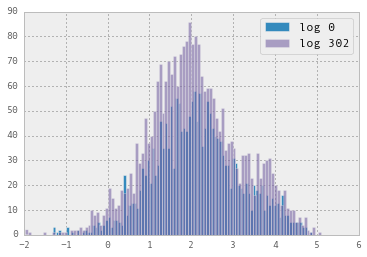

In [64]:
np.log(df_no_centers[df_no_centers.Metadata_Treatment==0].Euclidian_norm_centers).hist(bins=100)
np.log(df_no_centers[df_no_centers.Metadata_Treatment!=0].Euclidian_norm_centers).hist(bins=100, alpha=0.6)
plt.legend(('log 0','log 302'))

In [65]:
np.sum(df_no_centers.Metadata_Treatment==0), np.sum(df_no_centers.Metadata_Treatment!=0)

(1935, 2621)

In [66]:
df_no_centers.shape

(4556, 188)

In [67]:
df_no_centers.columns.tolist()

['ImageNumber',
 'ObjectNumber',
 'Metadata_Experiment',
 'Metadata_Experimenter',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_Set',
 'Metadata_Treatment',
 'Metadata_Type',
 'Metadata_cvsp',
 'AreaShape_Area',
 'AreaShape_Compactness',
 'AreaShape_Eccentricity',
 'AreaShape_EulerNumber',
 'AreaShape_Extent',
 'AreaShape_FormFactor',
 'AreaShape_MajorAxisLength',
 'AreaShape_MaxFeretDiameter',
 'AreaShape_MaximumRadius',
 'AreaShape_MeanRadius',
 'AreaShape_MedianRadius',
 'AreaShape_MinFeretDiameter',
 'AreaShape_MinorAxisLength',
 'AreaShape_Orientation',
 'AreaShape_Perimeter',
 'AreaShape_Solidity',
 'AreaShape_Zernike_0_0',
 'AreaShape_Zernike_1_1',
 'AreaShape_Zernike_2_0',
 'AreaShape_Zernike_2_2',
 'AreaShape_Zernike_3_1',
 'AreaShape_Zernike_3_3',
 'AreaShape_Zernike_4_0',
 'AreaShape_Zernike_4_2',
 'AreaShape_Zernike_4_4',
 'AreaShape_Zernike_5_1',
 'AreaShape_Zernike_5_3',
 'AreaShape_Zernike_5_5',
 'AreaShape_Zernike_6_0',
 'AreaShape_Zernike

Are the two distributions different? (control and with TPX2 added)


In [68]:
%R -i df_no_centers

In [137]:
%%R
head(df_no_centers)
class(df_no_centers)
print(dim(df_no_centers[df_no_centers$Metadata_Treatment==0,]))
print(dim(df_no_centers[df_no_centers$Metadata_Treatment!=0,]))
print(table(df_no_centers$Metadata_Treatment))
print(tapply(df_no_centers$Euclidian_norm_centers,df_no_centers$Metadata_Treatment,mean,na.omit=TRUE))
print(tapply(df_no_centers$Euclidian_norm_centers,df_no_centers$Metadata_Treatment,var))

print('log transformed: ')
print(names((tapply(df_no_centers$Euclidian_norm_centers,df_no_centers$Metadata_Treatment,log,simplify=TRUE))))



print(tapply(df_no_centers$Euclidian_norm_centers,df_no_centers$Metadata_Treatment,mean,na.omit=TRUE))
print(tapply(df_no_centers$Euclidian_norm_centers,df_no_centers$Metadata_Treatment,var))

[1] 1935  188
[1] 2621  188

   0  302 
1935 2621 
       0      302 
14.20747 14.21875 
       0      302 
305.7277 345.9092 
[1] "log transformed: "
[1] "0"   "302"
       0      302 
14.20747 14.21875 
       0      302 
305.7277 345.9092 



	Two-sample Kolmogorov-Smirnov test

data:  df_no_centers[df_no_centers$Metadata_Treatment == 0, ]$Euclidian_norm_centers and df_no_centers[df_no_centers$Metadata_Treatment != 0, ]$Euclidian_norm_centers
D = 0.046607, p-value = 0.01587
alternative hypothesis: two-sided



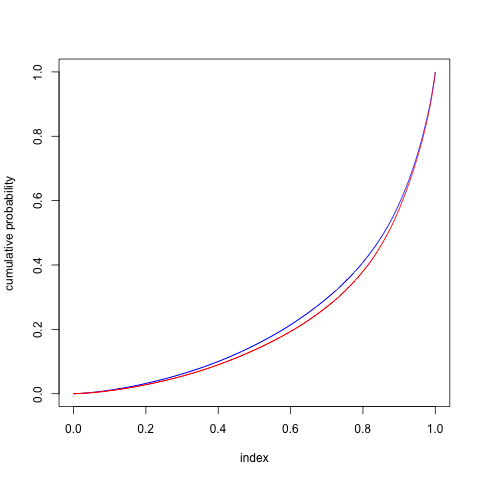

In [138]:
%%R
C=df_no_centers[df_no_centers$Metadata_Treatment==0,]$Euclidian_norm_centers
E=df_no_centers[df_no_centers$Metadata_Treatment!=0,]$Euclidian_norm_centers
plot(seq(0,1,length=length(C)), cumsum(sort(C)/sum(C)),type='l',col='blue',ylab='cumulative probability',xlab='index')
lines( seq(0,1,length=length(E)), cumsum(sort(E)/sum(E)), col='red')

print(ks.test(df_no_centers[df_no_centers$Metadata_Treatment==0,]$Euclidian_norm_centers,df_no_centers[df_no_centers$Metadata_Treatment!=0,]$Euclidian_norm_centers,))

In [139]:
%%R
class(as.numeric(C))

[1] "numeric"


In [140]:
%%R
source('skew.R')
print(skew(C))
print(skew(log(C)))
print(skew(sqrt(C)))



#print(hist(C))

 p.value     skew 
0.000000 2.714273 
   p.value       skew 
0.25726747 0.03630151 
p.value    skew 
0.00000 1.43945 


A set of variables that usually perform great when building a classifier, but not the easiest to interpret when selecting features, are **Zernike moments/polynomials**. We will specify them, so that we can compare model preformance with and without them.

In [141]:
Zernike_data=[]
for var in df.columns:
    if re.match('.*Zernike.*',var) != None:
        Zernike_data.append(re.match('.*Zernike.*',var).group(0))

Let's put it all together. For now, we want to drop all **'Meta'** columns, all **'locator'** columns and all **'NA'** columns. We will keep the **Euclidian distance** for now, as well as the **Zernike polynomials**. 

In [142]:
meta_data.extend(obj_locators)
meta_data.extend(NAs)

In [143]:
to_drop=list(set(meta_data))

In [144]:
len(to_drop)

29

In [145]:
df.shape

(4556, 204)

The code below was used initially. We will, however, use the curated lists of variables to drop. Currently, there are 39 items on it.

In [146]:
#df_cont=df.drop(to_drop,axis=1)
#df_cont.shape #(4556, 174)

In [147]:
#df_cont.to_csv('../Data/TPX2_df_with_Zernike.csv')

In [148]:
to_drop=NAs + list(meta.meta_columns) + list(object_locators.loc_columns)
len(to_drop)

39

In [149]:
#pd.Series(to_drop).to_csv('../Data/columns_to_drop.txt', sep='\t')

In [150]:
df_cont=df.drop(to_drop,axis=1)
df_cont.shape

(4556, 166)

From now on, df_cont IS the data frame to use.

In [151]:
df_cont.columns[-3:]

Index([u'Mean_FilteredChromatin_Number_Object_Number', u'Parent_Spindles',
       u'Euclidian_norm_centers'],
      dtype='object')

Changing the **target** variable encoding.

In [152]:
map_dict=dict(zip(list(np.unique(df['Metadata_Treatment'])),[0,1]))

In [153]:
map_dict

{0: 0, 302: 1}

In [154]:
df_cont['Metadata_Treatment']=df['Metadata_Treatment'].map(map_dict)

In [155]:
df_cont.shape

(4556, 167)

In [156]:
np.unique(df_cont['Metadata_Treatment'])

array([0, 1])

In [157]:
Y_binary=df['Metadata_Treatment'].map(map_dict)

In [158]:
len(Y_binary), np.sum(Y_binary), float(len(Y_binary))/np.sum(Y_binary)

(4556, 2621, 1.7382678367035482)

Almost balanced, but not perfect. The experimental treatmnet is underrepresented.

In [159]:
%R -i Y_binary

##IIb. Testing for normality

A number of variables show non-normal distribution. Some of them might be a mixture of Gaussians, though.

In [160]:
%R -i df_cont

The dataset is not fully balanced, but has the Y variable. 

In [161]:
%%R
print(dim(df_cont))
df_cont[length(names(df_cont))]

[1] 4556  167
     Metadata_Treatment
0                     0
1                     0
2                     0
3                     0
4                     0
5                     0
6                     0
7                     0
8                     0
9                     0
10                    0
11                    0
12                    0
13                    0
14                    0
15                    0
16                    0
17                    0
18                    0
19                    0
20                    0
21                    0
22                    0
23                    0
24                    0
25                    0
26                    0
27                    0
28                    0
29                    0
30                    0
31                    0
32                    0
33                    0
34                    0
35                    0
36                    0
37                    0
38                    0
39                    0
40

In [162]:
%%R
apply(df_cont, 2, var, na.rm=TRUE)
apply(df_cont, 2, mean, na.rm=TRUE)
apply(df_cont, 2, sd, na.rm=TRUE)
sort(apply(df_cont,2, function(x){(sd(x)/abs(mean(x)))*100}))

print(sum(sort(apply(df_cont, 2, function(x){ks.test(x, 'pnorm',mean(x), sd(x))$p.value}))>0.1))
print(sum(sort(apply(df_cont, 2, function(x){ks.test(log(x), 'pnorm',mean(log(x)), sd(log(x)))$p.value}))>0.1))
print(sum(sort(apply(df_cont, 2, function(x){ks.test(sqrt(x), 'pnorm',mean(sqrt(x)), sd(sqrt(x)))$p.value}))>0.1))




print('1')
print(sort(apply(df_cont, 2, function(x){ks.test(x, 'pnorm',mean(x), sd(x))$p.value})))
print('2')
print(sort(apply(df_cont, 2, function(x){ks.test(log(x), 'pnorm',mean(log(x)), sd(log(x)))$p.value})))
print('3')
print(sort(apply(df_cont, 2, function(x){ks.test(sqrt(x), 'pnorm',mean(sqrt(x)), sd(sqrt(x)))$p.value})))


#hist(df_cont$AreaShape_Orientation,bins=100) #looks like uniform - try inverse tranform
#hist(log(abs(df_cont$Mean_FilteredChromatin_AreaShape_EulerNumber+1)))
#hist(sqrt(df_cont$AreaShape_Zernike_5_1))
#ks.test(sqrt(df_cont$AreaShape_Zernike_5_1),'pnorm',mean(sqrt(df_cont$AreaShape_Zernike_5_1)),sd(sqrt(df_cont$AreaShape_Zernike_5_1)))
#qqnorm(sqrt(df_cont$AreaShape_Zernike_5_1))
#qqnorm(log(df_cont$AreaShape_Zernike_5_1))
#qqnorm(df_cont$AreaShape_Zernike_5_1)

[1] 2
[1] 0
[1] 22
[1] "1"
                                                    AreaShape_Area 
                                                      0.000000e+00 
                                             AreaShape_Compactness 
                                                      0.000000e+00 
                                            AreaShape_Eccentricity 
                                                      0.000000e+00 
                                             AreaShape_EulerNumber 
                                                      0.000000e+00 
                                                  AreaShape_Extent 
                                                      0.000000e+00 
                                         AreaShape_MajorAxisLength 
                                                      0.000000e+00 
                                        AreaShape_MaxFeretDiameter 
                                                      0.000000e+00 
                     


	One-sample Kolmogorov-Smirnov test

data:  sqrt(df_cont$Intensity_StdIntensityEdge_Rhodamine)
D = 0.14364, p-value < 2.2e-16
alternative hypothesis: two-sided



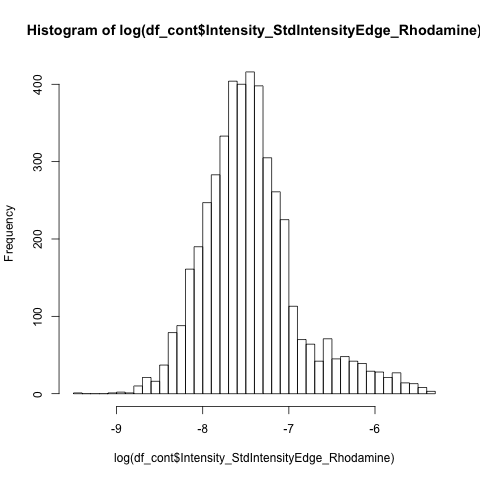

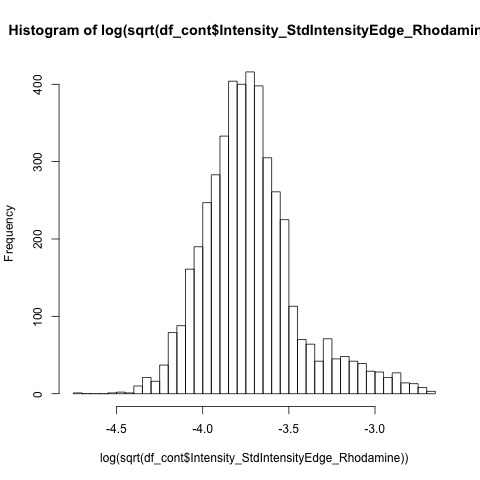

In [163]:
%%R
hist(log(df_cont$Intensity_StdIntensityEdge_Rhodamine),breaks=50)
hist(log(sqrt(df_cont$Intensity_StdIntensityEdge_Rhodamine)),breaks=50)
ks.test(log(df_cont$Intensity_StdIntensityEdge_Rhodamine),'pnorm',mean(log(df_cont$Intensity_StdIntensityEdge_Rhodamine)),sd(log(df_cont$Intensity_StdIntensityEdge_Rhodamine)))
ks.test(sqrt(df_cont$Intensity_StdIntensityEdge_Rhodamine),'pnorm',mean(sqrt(df_cont$Intensity_StdIntensityEdge_Rhodamine)),sd(sqrt(df_cont$Intensity_StdIntensityEdge_Rhodamine)))

In [164]:
%%R
source('skew.R')
source('kurtosis.R')
print(dim(df_cont))
#print(grep('Meta', names(df_cont),value=TRUE ))
#print(names(df_cont)[! names(df_cont) %in% grep('Meta', names(df_cont),value=TRUE )])
apply(df_cont, 2, function(x){skew(x)[1]})

[1] 4556  167
                                                    AreaShape_Area 
                                                      0.000000e+00 
                                             AreaShape_Compactness 
                                                      0.000000e+00 
                                            AreaShape_Eccentricity 
                                                      1.000000e+00 
                                             AreaShape_EulerNumber 
                                                               NaN 
                                                  AreaShape_Extent 
                                                      1.000000e+00 
                                              AreaShape_FormFactor 
                                                      1.000000e+00 
                                         AreaShape_MajorAxisLength 
                                                      0.000000e+00 
                                  

Creating summary statistics for the dataset.

In [165]:
%%R 
library(caret)
library(psych)
#write.csv(df_cont,'../Data/TPX2_df_with_bin_Y.csv')

df_cont_no_Y=df_cont[,names(df_cont)[1:(length(names(df_cont))-1)]]
#write.csv(df_cont_no_Y,'../Data/TPX2_df_cont_no_Y.csv')

#write.csv(describe(df_cont_no_Y), '../Data/TPX2_df_cont_no_Y_summary.csv')


for (variable in names(df_cont_no_Y)){
    df_cont_no_Y[,variable]=as.numeric(df_cont_no_Y[,variable])
}

dim(df_cont_no_Y)



Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘psych’

The following object is masked _by_ ‘.GlobalEnv’:

    skew

The following object is masked from ‘package:ggplot2’:

    %+%

[1] 4556  166


##IIc. Analyzing collinearity

One way to detect collinearity is through the use of variance inflation factor, [VIF](http://www.how2stats.net/2011/09/tolerance.html) 1/(1-Rsq), which is a reciprocal of [tolerance/coeffincient of alienation](http://www.how2stats.net/2011/09/tolerance.html) (1-Rsq). The lower the VIF the better (the lower the multicollinearity). It indicates the magnitude of the inflation in the standard errors associated with a particular paramater estimate (weight) that is due to multicollinearity. One thing to have in mind is that it was developed for linear models and may have rather limited usability (and give unexpected results) in other cases.

In [166]:
%%R 

dim(df_cont)

[1] 4556  167


In [167]:
%%R
#library(plyr)
print(unique(df_cont[,'Metadata_Treatment']))

df_cont=as.data.frame(df_cont)
print(class(df_cont[,1]))
print(unique(df_cont$Metadata_Treatment))
convert_data_type=function(data_frame){

    for (col in names(data_frame)){
        data_frame[,col]<-as.numeric(data_frame[,col])
    }
    
    return(data_frame)
}

df_cont=convert_data_type(df_cont)
print(class(df_cont[,1]))

#df_cont$Metadata_Treatment=as.character(df_cont$Metadata_Treatment)
#print(class(df_cont$Metadata_Treatment))
#df_cont$Metadata_Treatment=as.factor(df_cont$Metadata_Treatment)
#print(class(df_cont$Metadata_Treatment))
#transform(df_cont, as.numeric(df.cont[,]))
str(df_cont$Metadata_Treatment)
head(df_cont$Metadata_Treatmen)

[1] 0 1
[1] "array"
[1] 0 1
[1] "numeric"
 num [1:4556] 0 0 0 0 0 0 0 0 0 0 ...
[1] 0 0 0 0 0 0


In [168]:
%%R
print(dim(df_cont))
print(dim(head(df_cont[,-length(names(df_cont))])))
print(dim(head(df_cont[,!(names(df_cont) %in% c('AreaShape_EulerNumber','Metadata_Treatment'))])))
TPX2.original.names.corrs=names(df_cont[,!(names(df_cont) %in% c('AreaShape_EulerNumber','Metadata_Treatment'))])
print(length(TPX2.original.names.corrs))
#write.csv(TPX2.original.names.corrs,file='../Data/TPX2_rcorr_all_P_adj_bonf_005_df_names.csv')
df_cont.cp=df_cont[,!(names(df_cont) %in% c('AreaShape_EulerNumber','Metadata_Treatment'))]
print(names(df_cont.cp))
names(df_cont.cp)=seq(1,dim(head(df_cont[,!(names(df_cont) %in% c('AreaShape_EulerNumber','Metadata_Treatment'))]))[2],1)


[1] 4556  167
[1]   6 166
[1]   6 165
[1] 165
  [1] "AreaShape_Area"                                                    
  [2] "AreaShape_Compactness"                                             
  [3] "AreaShape_Eccentricity"                                            
  [4] "AreaShape_Extent"                                                  
  [5] "AreaShape_FormFactor"                                              
  [6] "AreaShape_MajorAxisLength"                                         
  [7] "AreaShape_MaxFeretDiameter"                                        
  [8] "AreaShape_MaximumRadius"                                           
  [9] "AreaShape_MeanRadius"                                              
 [10] "AreaShape_MedianRadius"                                            
 [11] "AreaShape_MinFeretDiameter"                                        
 [12] "AreaShape_MinorAxisLength"                                         
 [13] "AreaShape_Orientation"                         

In [331]:
%%R 

test = df_cont[,-length(names(df_cont))]
dim(test)
cor(test)

                                                                   AreaShape_Area
AreaShape_Area                                                       1.0000000000
AreaShape_Compactness                                               -0.0448161181
AreaShape_Eccentricity                                              -0.0526962365
AreaShape_EulerNumber                                                          NA
AreaShape_Extent                                                    -0.0706811673
AreaShape_FormFactor                                                -0.1895205633
AreaShape_MajorAxisLength                                            0.8075701625
AreaShape_MaxFeretDiameter                                           0.8199734521
AreaShape_MaximumRadius                                              0.8087541029
AreaShape_MeanRadius                                                 0.7699587877
AreaShape_MedianRadius                                               0.7566919866
AreaShape_MinFer

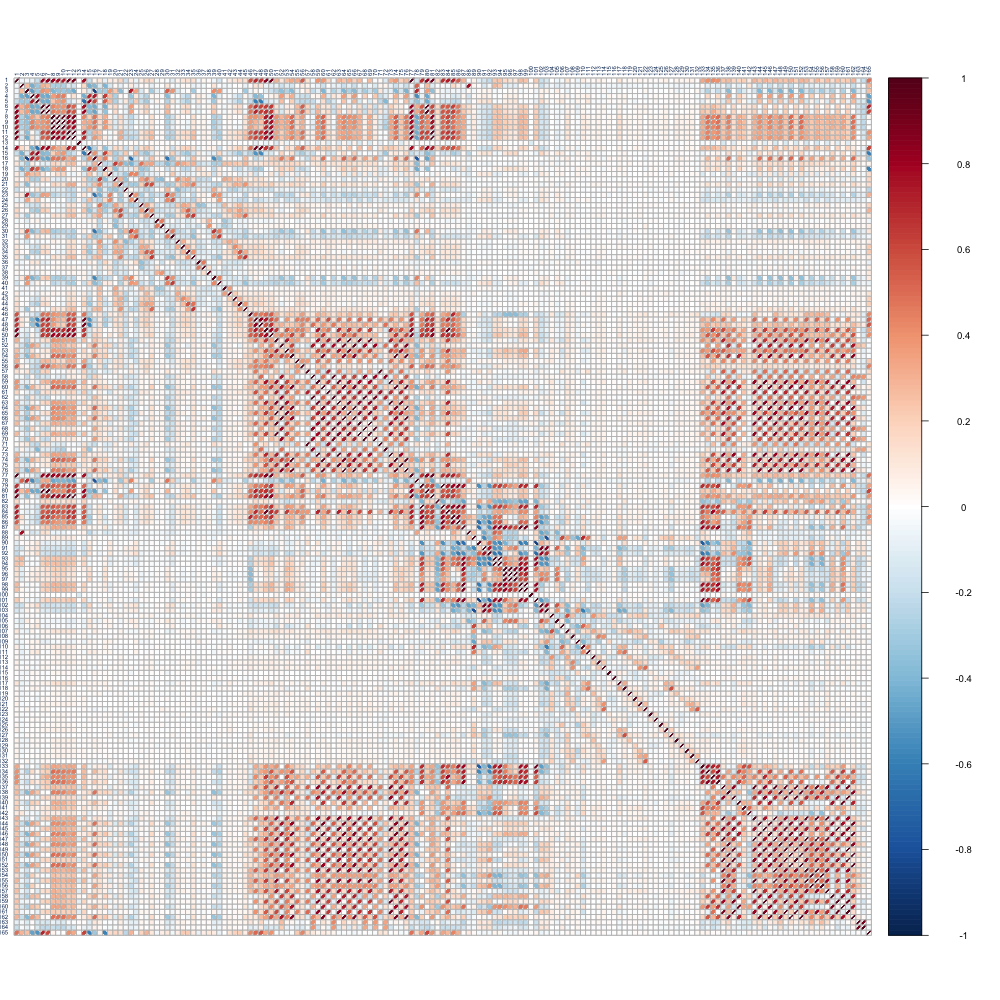

In [169]:
%%R -w 1000 -h 1000 -u px
library(corrplot)
corr.all=cor(df_cont.cp)
col2 <- colorRampPalette(rev(c("#67001F", "#B2182B", "#D6604D", "#F4A582", "#FDDBC7", "#FFFFFF", "#D1E5F0", "#92C5DE", "#4393C3", "#2166AC", "#053061")))


#corr.all
#png('../Plots/TPX2_rcorr_plot.png',width=2000, height=2000)
#par(cex=0.8)
corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]),tl.col="#053061",tl.cex=0.5)
dev.off()
corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]),tl.col="#053061",tl.cex=0.5)


In [170]:
%%R
names(df_cont.cp)

  [1] "1"   "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9"   "10"  "11"  "12" 
 [13] "13"  "14"  "15"  "16"  "17"  "18"  "19"  "20"  "21"  "22"  "23"  "24" 
 [25] "25"  "26"  "27"  "28"  "29"  "30"  "31"  "32"  "33"  "34"  "35"  "36" 
 [37] "37"  "38"  "39"  "40"  "41"  "42"  "43"  "44"  "45"  "46"  "47"  "48" 
 [49] "49"  "50"  "51"  "52"  "53"  "54"  "55"  "56"  "57"  "58"  "59"  "60" 
 [61] "61"  "62"  "63"  "64"  "65"  "66"  "67"  "68"  "69"  "70"  "71"  "72" 
 [73] "73"  "74"  "75"  "76"  "77"  "78"  "79"  "80"  "81"  "82"  "83"  "84" 
 [85] "85"  "86"  "87"  "88"  "89"  "90"  "91"  "92"  "93"  "94"  "95"  "96" 
 [97] "97"  "98"  "99"  "100" "101" "102" "103" "104" "105" "106" "107" "108"
[109] "109" "110" "111" "112" "113" "114" "115" "116" "117" "118" "119" "120"
[121] "121" "122" "123" "124" "125" "126" "127" "128" "129" "130" "131" "132"
[133] "133" "134" "135" "136" "137" "138" "139" "140" "141" "142" "143" "144"
[145] "145" "146" "147" "148" "149" "150" "151" "152" "153" "154

In [171]:
%%R
class(corr.all)
#save(corr.all,file='../Data/TPX2_correlations_all.Robj')
#save(df_cont.cp, file='../Data/TPX2_df_cont.cp.Robj')

[1] "matrix"


Above we can see our complete correlation matrix. Clearly, there is quite some positive correlation among explanatory variables (and some negative). Easiest way to identify the correlations is by sorting the r values and assigning p-value to quantify the effect size. For selection of significant features, we will use **FDR (Benjamini-Hochberg)** correction for multiple comparisons.

In [172]:
%%R
library(Hmisc)
library(reshape)
rcorr.all=rcorr(as.matrix(df_cont.cp)) #has to be a matrix
#print(str(rcorr.all))


#print(dim((rcorr.all$P)))
print(head(rcorr.all$P[1:5,1:5]))
rcorr.all.P=as.vector(matrix(rcorr.all$P,dim(rcorr.all$P)[1]*dim(rcorr.all$P)[1],1)) #linearize matrix
rcorr.all.P.adj=p.adjust(rcorr.all.P,method='BH')
#print(head(rcorr.all.P))
rcorr.all.P.adj=matrix(rcorr.all.P.adj,dim(rcorr.all$P)[1],dim(rcorr.all$P)[2])
print(dim(rcorr.all.P.adj))
print(head(rcorr.all.P.adj[1:5,1:5]))

print(173*173)
#rcorr.all$P[order(rcorr.all$P[,1]),]

print(head(which(rcorr.all$P <= 0.05, arr.ind=TRUE),10L))
print(dim(which(rcorr.all$P<=1,arr.ind=TRUE))) #total number of comparisons

print(dim(which(rcorr.all$P<=0.05,arr.ind=TRUE)))
print(dim(which(rcorr.all$P<=0.01,arr.ind=TRUE)))

print(dim(which(rcorr.all.P.adj<=0.05,arr.ind=TRUE)))

Loading required package: grid
Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:caret’:

    cluster

Loading required package: Formula

Attaching package: ‘Hmisc’

The following object is masked from ‘package:psych’:

    describe

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

             1           2            3            4  5
1           NA 0.002480623 0.0003731284 1.792504e-06  0
2 2.480623e-03          NA 0.0000000000 0.000000e+00  0
3 3.731284e-04 0.000000000           NA 0.000000e+00  0
4 1.792504e-06 0.000000000 0.0000000000           NA  0
5 0.000000e+00 0.000000000 0.0000000000 0.000000e+00 NA
[1] 165 165
             [,1]        [,2]         [,3]         [,4] [,5]
[1,]           NA 0.004227057 0.0006827734 3.741528e-06    0
[2,] 4.227057e-03          NA 0.0000000000 0.000000e+00    0
[3,] 6.827734e-04 0.000000000           NA 0.000000e+00    0
[4,] 

In [173]:
%%R
print(dim(which(rcorr.all.P.adj<=0.05,arr.ind=TRUE)))
print(head(which(rcorr.all.P.adj<=0.05,arr.ind=TRUE)))

print(rcorr.all.P.adj[head(which(rcorr.all.P.adj<=0.05,arr.ind=TRUE))])
rcorr.all.P.adj.BH.005=cbind(which(rcorr.all.P.adj<=0.05,arr.ind=TRUE),rcorr.all.P.adj[which(rcorr.all.P.adj<=0.05,arr.ind=TRUE)])
print(head(rcorr.all.P.adj.BH.005))


[1] 18412     2
     row col
[1,]   2   1
[2,]   3   1
[3,]   4   1
[4,]   5   1
[5,]   6   1
[6,]   7   1
[1] 4.227057e-03 6.827734e-04 3.741528e-06 0.000000e+00 0.000000e+00
[6] 0.000000e+00
     row col             
[1,]   2   1 4.227057e-03
[2,]   3   1 6.827734e-04
[3,]   4   1 3.741528e-06
[4,]   5   1 0.000000e+00
[5,]   6   1 0.000000e+00
[6,]   7   1 0.000000e+00


How many variables show correlation to other variables?

In [174]:
%%R
print(length(unique(rcorr.all.P.adj.BH.005[,1])))
correlating.regressors=matrix(unique(rcorr.all.P.adj.BH.005[,1]))
print(class(dim(rcorr.all.P.adj.BH.005[rcorr.all.P.adj.BH.005[,1]==4,])[1]))

no_of_corrs=vector('list',length=length(correlating.regressors))
#no_of_corrs <- numeric(length(correlating.regressors))
#print(class(no_of_corrs))
#print(head(no_of_corrs))
#print(length(no_of_corrs))
for (i in 1:dim(correlating.regressors)[1]) {
    #print(i)
    #print(no_of_corrs[i])
    no_of_corrs[[i]]=dim(rcorr.all.P.adj.BH.005[rcorr.all.P.adj.BH.005[,1]==correlating.regressors[i,1],])[1]
    #no_of_corrs[i] <- dim(rcorr.all.P.adj.005[rcorr.all.P.adj.005[,1]==correlating.regressors[i,1],])[1]
}
print(unlist(no_of_corrs))

cbind(correlating.regressors,unlist(no_of_corrs))

[1] 165
[1] "integer"
  [1] 133 124 110 124 123 124 137 138 139 140 142 135 113 113 120 118 119  88
 [19] 109 104 121 130  96  73 109  48 124 105  96  80 117  72  66 117 127  92
 [37]  83 100 114 147 135 136 141 145 144 116 137 135 125 128 125 110 128 132
 [55] 124 114 130 120 145 119 133 137  97 122 135 128 127 141 128 127 124 140
 [73] 114 127 142 141 137 116 106 115 127 136 118 114 123 132 131 111 112 123
 [91] 132 128 122 104 128  95 112  98  83 102  61  86  40  63  75  73  71  75
[109] 137 134 121 132 125 129 120 124 129 117 135 123 118 123 134 127 117 128
[127] 122 128 127 137 127 132 138 123 117 126 116 131 107 112  90 141 113  52
[145] 115 121 112 108 102  86  76  58  45  48  76  70  43  81  56  80  77  54
[163]  46  51  24
       [,1] [,2]
  [1,]    2  133
  [2,]    3  124
  [3,]    4  110
  [4,]    5  124
  [5,]    6  123
  [6,]    7  124
  [7,]    8  137
  [8,]    9  138
  [9,]   10  139
 [10,]   11  140
 [11,]   12  142
 [12,]   14  135
 [13,]   15  113
 [14,]   16  113
 [1

Looks like all of them to some extent correlate with something else. Even the p-adjusted correlation matrix shows a lot of possible correlations. FDR, however is not too stringent. Let's try **Bonferroni** (procedure is exactly the same, just loaded into one cell).

In [175]:
%%R
#1
print('original p-value matrix:')
print(head(rcorr.all$P[1:5,1:5]))

rcorr.all.P.adj.bonf=p.adjust(rcorr.all.P,method="bonferroni")
rcorr.all.P.adj.bonf=matrix(rcorr.all.P.adj.bonf,dim(rcorr.all$P)[1],dim(rcorr.all$P)[2])

print(dim(rcorr.all.P.adj.bonf))

print('adjusted p-value matrix:')
print(head(rcorr.all.P.adj.bonf[1:5,1:5]))

#2
print(dim(which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE)))
print('indices for the significant cells:')
print(head(which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE)))
print('p-values:')
print(rcorr.all.P.adj.bonf[head(which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE))])
print('indices for the significant cells with p-values: ')
rcorr.all.P.adj.bonf.005=cbind(which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE),rcorr.all.P.adj.bonf[which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE)])
print(head(rcorr.all.P.adj.bonf.005,20L))

#3
print(length(unique(rcorr.all.P.adj.bonf.005[,1])))
correlating.regressors.bonf=matrix(unique(rcorr.all.P.adj.bonf.005[,1]))

no_of_corrs.bonf=vector('list',length=length(correlating.regressors.bonf))
for (i in 1:dim(correlating.regressors.bonf)[1]) {
    no_of_corrs.bonf[[i]]=dim(rcorr.all.P.adj.bonf.005[rcorr.all.P.adj.bonf.005[,1]==correlating.regressors.bonf[i,1],])[1]
}
print(unlist(no_of_corrs.bonf))

cbind(correlating.regressors.bonf,unlist(no_of_corrs.bonf))



[1] "original p-value matrix:"
             1           2            3            4  5
1           NA 0.002480623 0.0003731284 1.792504e-06  0
2 2.480623e-03          NA 0.0000000000 0.000000e+00  0
3 3.731284e-04 0.000000000           NA 0.000000e+00  0
4 1.792504e-06 0.000000000 0.0000000000           NA  0
5 0.000000e+00 0.000000000 0.0000000000 0.000000e+00 NA
[1] 165 165
[1] "adjusted p-value matrix:"
           [,1] [,2] [,3]       [,4] [,5]
[1,]         NA    1    1 0.04850517    0
[2,] 1.00000000   NA    0 0.00000000    0
[3,] 1.00000000    0   NA 0.00000000    0
[4,] 0.04850517    0    0         NA    0
[5,] 0.00000000    0    0 0.00000000   NA
[1] 12972     2
[1] "indices for the significant cells:"
     row col
[1,]   4   1
[2,]   5   1
[3,]   6   1
[4,]   7   1
[5,]   8   1
[6,]   9   1
[1] "p-values:"
[1] 0.04850517 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
[1] "indices for the significant cells with p-values: "
      row col             
 [1,]   4   1 4.85051

Let's visualize Bonferroni corrected p-values.    
Corrplot does not have automatic functionality to deal with NAs, as these are values we don't care about (insignificant), we will re-code them into 1.0 here. 

In [176]:
%%R
rcorr.all.P.adj.bonf.noNA=rcorr.all.P.adj.bonf
rcorr.all.P.adj.bonf.noNA[is.na(rcorr.all.P.adj.bonf)==TRUE]=1.0
print(min(rcorr.all.P.adj.bonf.noNA))
print(max(rcorr.all.P.adj.bonf.noNA))
#max(-log10(rcorr.all.P.adj.bonf.noNA+(1e-12))[-log10(rcorr.all.P.adj.bonf.noNA+(1e-12))!=12])
print(min(-log10(rcorr.all.P.adj.bonf.noNA+(1e-12))[-log10(rcorr.all.P.adj.bonf.noNA+(1e-12))!=12]))
rcorr.all.negLog.P.adj.bonf.noNA=-log10(rcorr.all.P.adj.bonf.noNA+(1e-12))

[1] 0
[1] 1
[1] -4.343331e-13


Below: the darker the field, the more significant the correlation.

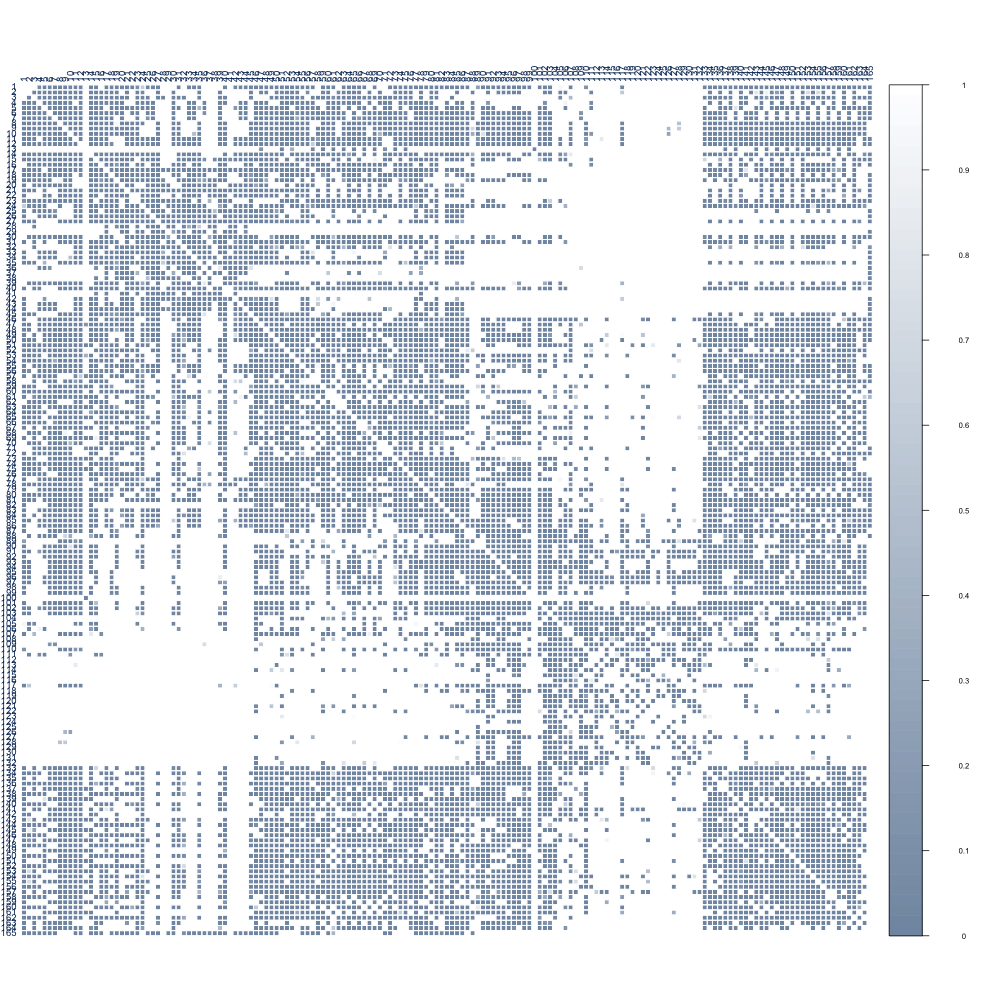

In [177]:
%%R -w 1000 -h 1000 -u px
library(corrplot)

col3 <- colorRampPalette(c("#053061",  "white"))

corr.all
#png('../Plots/TPX2_rcorr_plot.png',width=2000, height=2000)
par(cex=0.8)
#corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]))
#dev.off()
corrplot(rcorr.all.P.adj.bonf.noNA,is.corr = FALSE,method='shade', col=col3(dim(rcorr.all.P.adj.bonf.noNA)[2]),cl.lim=c(0,1),tl.col="#053061")



Below: the darker the field, the more significant the correlation. 

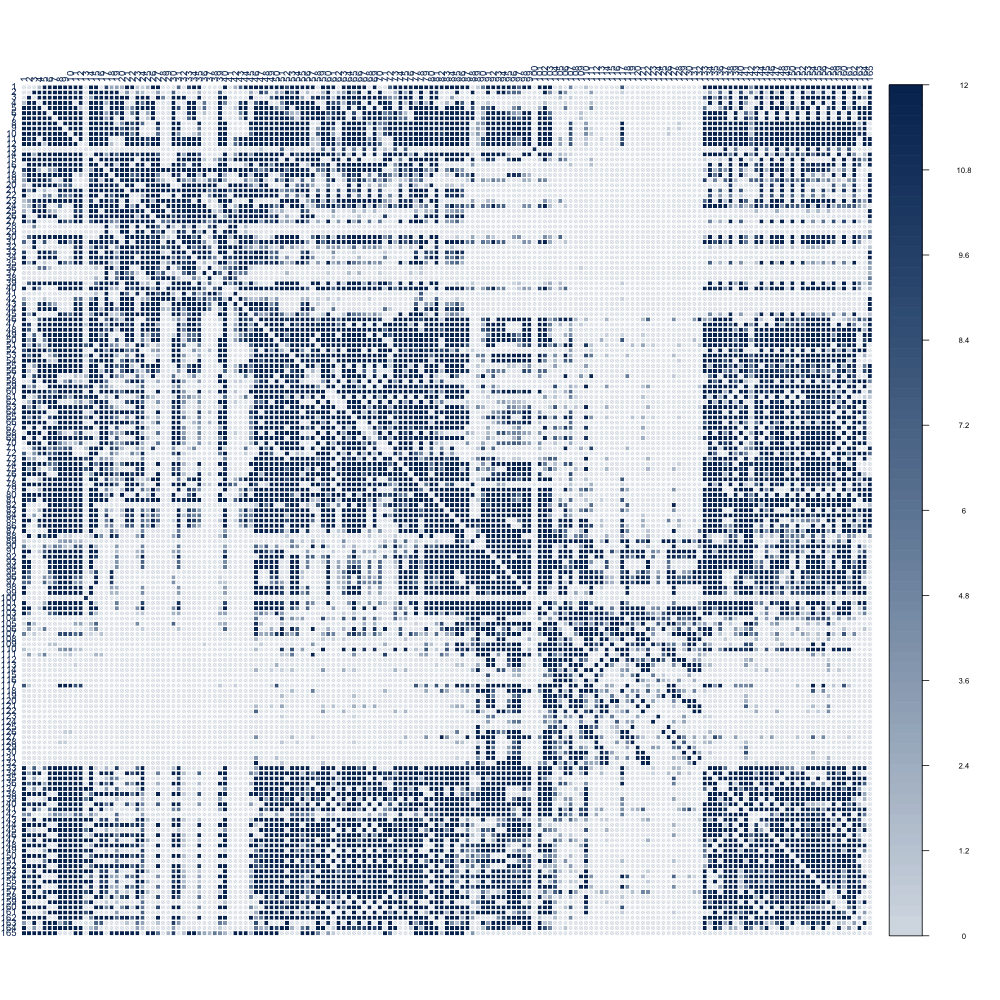

In [178]:
%%R -w 1000 -h 1000 -u px
library(corrplot)

col3 <- colorRampPalette(c( "white",'#D5DCE4',"#053061"))

corr.all
#png('../Plots/TPX2_rcorr_plot.png',width=2000, height=2000)
par(cex=0.8)
#corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]))
#dev.off()
corrplot(rcorr.all.negLog.P.adj.bonf.noNA,is.corr = FALSE,method='shade', col=col3(dim(rcorr.all.negLog.P.adj.bonf.noNA)[2]),cl.lim=c(-4.343331e-13,12),tl.col="#053061")

To make the output useful, we need to pull all the corellating regressors and associated p-values and sort them. We should get the strongest correlations. 

In [179]:
%%R
rcorr.all.P.adj.bonf.005=cbind(which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE),rcorr.all.P.adj.bonf[which(rcorr.all.P.adj.bonf<=0.05,arr.ind=TRUE)])
print(head(rcorr.all.P.adj.bonf.005,20L))
print(head(rcorr.all.P.adj.bonf.005[order(rcorr.all.P.adj.bonf.005[,3]),],100L))
rcorr.all.P.adj.bonf.005.df=as.data.frame(rcorr.all.P.adj.bonf.005[order(rcorr.all.P.adj.bonf.005[,3]),])
names(rcorr.all.P.adj.bonf.005.df)=c('x_idx_a','x_idx_b','p-value')
head(rcorr.all.P.adj.bonf.005.df)
#write.csv(rcorr.all.P.adj.bonf.005.df,file='../Data/TPX2_rcorr_all_P_adj_bonf_005_df.csv')

      row col             
 [1,]   4   1 4.850517e-02
 [2,]   5   1 0.000000e+00
 [3,]   6   1 0.000000e+00
 [4,]   7   1 0.000000e+00
 [5,]   8   1 0.000000e+00
 [6,]   9   1 0.000000e+00
 [7,]  10   1 0.000000e+00
 [8,]  11   1 0.000000e+00
 [9,]  12   1 0.000000e+00
[10,]  14   1 0.000000e+00
[11,]  15   1 0.000000e+00
[12,]  17   1 6.248868e-10
[13,]  18   1 2.275454e-03
[14,]  19   1 8.184587e-04
[15,]  20   1 8.279787e-03
[16,]  21   1 0.000000e+00
[17,]  22   1 0.000000e+00
[18,]  25   1 1.516542e-02
[19,]  26   1 0.000000e+00
[20,]  27   1 0.000000e+00
       row col  
  [1,]   5   1 0
  [2,]   6   1 0
  [3,]   7   1 0
  [4,]   8   1 0
  [5,]   9   1 0
  [6,]  10   1 0
  [7,]  11   1 0
  [8,]  12   1 0
  [9,]  14   1 0
 [10,]  15   1 0
 [11,]  21   1 0
 [12,]  22   1 0
 [13,]  26   1 0
 [14,]  27   1 0
 [15,]  34   1 0
 [16,]  35   1 0
 [17,]  40   1 0
 [18,]  44   1 0
 [19,]  45   1 0
 [20,]  46   1 0
 [21,]  47   1 0
 [22,]  48   1 0
 [23,]  49   1 0
 [24,]  50   1 0
 [25,]  

Ultimately, all the plots above illustrate that there are multiple colinear features in the data matrix. We will explore several ways to compensate for that below. 

Let's try stepwise **VIF selection**. 

In [180]:
%%R
modelVIF.null=glm(Metadata_Treatment ~ 1, family=binomial, data=df_cont)
modelVIF.1=glm(Metadata_Treatment ~ ., family=binomial, data=df_cont)

In [181]:
%%R
#print(summary(modelVIF.null))
print(anova(modelVIF.null,modelVIF.1))
print(AIC(modelVIF.null,modelVIF.1))

Analysis of Deviance Table

Model 1: Metadata_Treatment ~ 1
Model 2: Metadata_Treatment ~ AreaShape_Area + AreaShape_Compactness + 
    AreaShape_Eccentricity + AreaShape_EulerNumber + AreaShape_Extent + 
    AreaShape_FormFactor + AreaShape_MajorAxisLength + AreaShape_MaxFeretDiameter + 
    AreaShape_MaximumRadius + AreaShape_MeanRadius + AreaShape_MedianRadius + 
    AreaShape_MinFeretDiameter + AreaShape_MinorAxisLength + 
    AreaShape_Orientation + AreaShape_Perimeter + AreaShape_Solidity + 
    AreaShape_Zernike_0_0 + AreaShape_Zernike_1_1 + AreaShape_Zernike_2_0 + 
    AreaShape_Zernike_2_2 + AreaShape_Zernike_3_1 + AreaShape_Zernike_3_3 + 
    AreaShape_Zernike_4_0 + AreaShape_Zernike_4_2 + AreaShape_Zernike_4_4 + 
    AreaShape_Zernike_5_1 + AreaShape_Zernike_5_3 + AreaShape_Zernike_5_5 + 
    AreaShape_Zernike_6_0 + AreaShape_Zernike_6_2 + AreaShape_Zernike_6_4 + 
    AreaShape_Zernike_6_6 + AreaShape_Zernike_7_1 + AreaShape_Zernike_7_3 + 
    AreaShape_Zernike_7_5 + AreaSha

In [182]:
%%R
print(names(summary(modelVIF.1)))
print(dim(summary(modelVIF.1)$coefficients))
print(summary(modelVIF.1))

print('***')
print(summary(modelVIF.1)$coefficients[,4][summary(modelVIF.1)$coefficients[,4]<0.001])
modelVIF_1_0_001<-as.data.frame(summary(modelVIF.1)$coefficients[,4][summary(modelVIF.1)$coefficients[,4]<0.001])
names(modelVIF_1_0_001)<-"P_lt_0_001"
#write.csv(modelVIF_1_0_001,file='../Data/TPX2_modelVIF_1_0_001.csv')

print('**')
print(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.01) & (summary(modelVIF.1)$coefficients[,4]>0.001)])
modelVIF_1_0_01<-as.data.frame(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.01) & (summary(modelVIF.1)$coefficients[,4]>0.001)])
names(modelVIF_1_0_01)<-"P_lt_0_01"
#write.csv(modelVIF_1_0_01,file='../Data/TPX2_modelVIF_1_0_01.csv')

print('*')
print(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.05) & (summary(modelVIF.1)$coefficients[,4]>0.01)])
modelVIF_1_0_05<-as.data.frame(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.05) & (summary(modelVIF.1)$coefficients[,4]>0.01)])
names(modelVIF_1_0_05)<-"P_lt_0_05"
#write.csv(modelVIF_1_0_05,file='../Data/TPX2_modelVIF_1_0_05.csv')

print('.')
print(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.1) & (summary(modelVIF.1)$coefficients[,4]>0.05)])
modelVIF_1_0_1<-as.data.frame(summary(modelVIF.1)$coefficients[,4][(summary(modelVIF.1)$coefficients[,4]<0.1) & (summary(modelVIF.1)$coefficients[,4]>0.05)])
names(modelVIF_1_0_1)<-"P_lt_0_1"
#write.csv(modelVIF_1_0_1,file='../Data/TPX2_modelVIF_1_0_1.csv')



 [1] "call"           "terms"          "family"         "deviance"      
 [5] "aic"            "contrasts"      "df.residual"    "null.deviance" 
 [9] "df.null"        "iter"           "deviance.resid" "coefficients"  
[13] "aliased"        "dispersion"     "df"             "cov.unscaled"  
[17] "cov.scaled"    
[1] 162   4

Call:
glm(formula = Metadata_Treatment ~ ., family = binomial, data = df_cont)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5511  -0.2322   0.0140   0.2809   3.4723  

Coefficients: (5 not defined because of singularities)
                                                                     Estimate
(Intercept)                                                         4.845e+00
AreaShape_Area                                                     -1.038e-06
AreaShape_Compactness                                               1.827e-01
AreaShape_Eccentricity                                             -8.989e-01
AreaShape_EulerNumber             

Word of caution. It actually takes a while to calculate vif for larger data set (i.e. large number of features). It also is quite a laborious process. We will, however, compare its outcome to the cross-validated lasso approach and decision tree method (both, far more efficient), to see whether they will arrive to pretty good approximation of this backward selection method.     
      
The first selection is a bulk selection.


In [183]:
%%R
library(HH)
print(dim(df_cont))

vif_selected=function(df, threshold=10){
  max_vif=500
  while (max_vif > threshold){
    vifs = vif(df)
    max_vif=max(vifs)
    print(vifs[vifs==max(vifs)])
    df=df[,names(df)[!names(df) %in% names(vifs[vifs==max(vifs)])]]
    
  }
  return(df)
}



Loading required package: latticeExtra
Loading required package: RColorBrewer

Attaching package: ‘latticeExtra’

The following object is masked from ‘package:ggplot2’:

    layer

Loading required package: multcomp
Loading required package: mvtnorm
Loading required package: TH.data
Loading required package: gridExtra

Attaching package: ‘HH’

The following object is masked from ‘package:psych’:

    logit

[1] 4556  167


In [184]:
%%R
dim(df_cont[,names(df_cont)[!names(df_cont) %in% c("Metadata_Treatment")]])
vifs.null=vif(df_cont[,names(df_cont)[!names(df_cont) %in% c("Metadata_Treatment")]])

print(vifs.null[vifs.null<10])
print(length(vifs.null[vifs.null<10]))
print(names(vifs.null[vifs.null<10]))

                                      AreaShape_EulerNumber 
                                                   1.999994 
                                           AreaShape_Extent 
                                                   4.764501 
                                      AreaShape_Orientation 
                                                   1.074703 
                                      AreaShape_Zernike_1_1 
                                                   4.840067 
                                      AreaShape_Zernike_2_2 
                                                   9.430049 
                                      AreaShape_Zernike_3_1 
                                                   4.928391 
                                      AreaShape_Zernike_3_3 
                                                   2.930372 
                                      AreaShape_Zernike_4_0 
                                                   3.386664 
                        

A number of features are shape related Zernike moments. Let's take them out to get the features they correlate with insted and compare model performance.

In [185]:
%%R
modelVIF.2=glm(Metadata_Treatment ~ ., family=binomial, data=df_cont[,c(names(vifs.null[vifs.null<10]),'Metadata_Treatment')])

In [186]:
%%R
print(AIC(modelVIF.null)) #null (total deviance)
print(AIC(modelVIF.1)) #max (all vars)
print(AIC(modelVIF.2)) #current (all above VIF=10 removed)

print(anova(modelVIF.1,modelVIF.2))

[1] 6214.272
[1] 2455.608
[1] 4506.54
Analysis of Deviance Table

Model 1: Metadata_Treatment ~ AreaShape_Area + AreaShape_Compactness + 
    AreaShape_Eccentricity + AreaShape_EulerNumber + AreaShape_Extent + 
    AreaShape_FormFactor + AreaShape_MajorAxisLength + AreaShape_MaxFeretDiameter + 
    AreaShape_MaximumRadius + AreaShape_MeanRadius + AreaShape_MedianRadius + 
    AreaShape_MinFeretDiameter + AreaShape_MinorAxisLength + 
    AreaShape_Orientation + AreaShape_Perimeter + AreaShape_Solidity + 
    AreaShape_Zernike_0_0 + AreaShape_Zernike_1_1 + AreaShape_Zernike_2_0 + 
    AreaShape_Zernike_2_2 + AreaShape_Zernike_3_1 + AreaShape_Zernike_3_3 + 
    AreaShape_Zernike_4_0 + AreaShape_Zernike_4_2 + AreaShape_Zernike_4_4 + 
    AreaShape_Zernike_5_1 + AreaShape_Zernike_5_3 + AreaShape_Zernike_5_5 + 
    AreaShape_Zernike_6_0 + AreaShape_Zernike_6_2 + AreaShape_Zernike_6_4 + 
    AreaShape_Zernike_6_6 + AreaShape_Zernike_7_1 + AreaShape_Zernike_7_3 + 
    AreaShape_Zernike_7_5 + A

In [187]:
%%R
sum(is.na(df_cont[,c(names(vifs.null[vifs.null<10]))]))

[1] 0


[1] 0


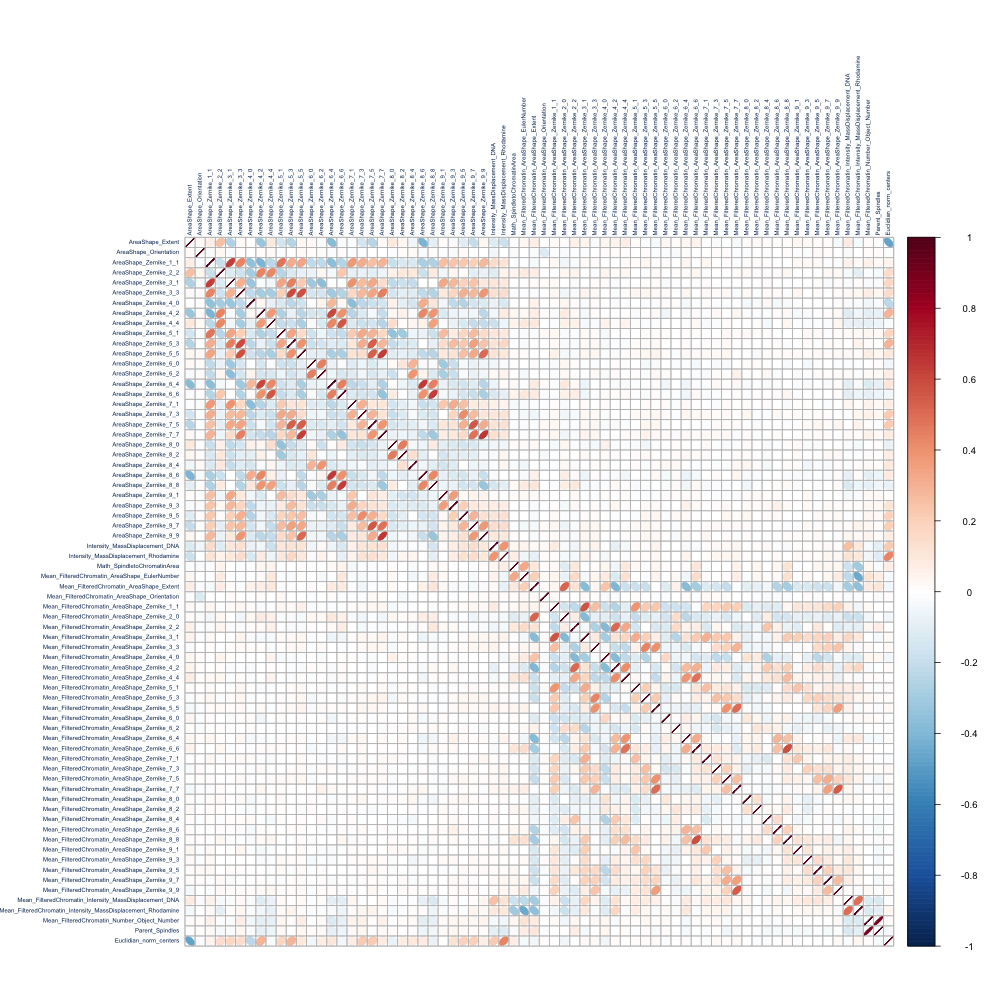

In [188]:
%%R -w 1000 -h 1000 -u px
library(corrplot)
to.test=df_cont[,c(names(vifs.null[vifs.null<10]))] 
to.test=to.test[,!names(to.test) %in% c('AreaShape_EulerNumber')]

corr.all=cor( to.test)
print(sum(is.na(corr.all)))
#which(is.na(corr.all),arr.ind=TRUE)

#col2 <- colorRampPalette(rev(c("#67001F", "#B2182B", "#D6604D", "#F4A582", "#FDDBC7", "#FFFFFF", "#D1E5F0", "#92C5DE", "#4393C3", "#2166AC", "#053061")))


#corr.all
#png('../Data/TPX2_rcorr_plot.png',width=2000, height=2000)
#par(cex=0.8)
#corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]))
#dev.off()
corrplot(corr.all, method='ellipse',col=col2(dim(df_cont.cp)[2]),tl.col="#053061",tl.cex=0.5)

Removal below is a bulk removal, which seems rather strict (leaves only 69 variables - plotted below).

In [189]:
%%R
df.1=df_cont[,names(df_cont)[!names(df_cont) %in% c("Metadata_Treatment")]] #all 
df.2=df.1[,names(df.1)[!names(df.1) %in% names(vifs.null[vifs.null==max(vifs.null)])]] #batch removal
vifs.1=vif(df.2)

In [190]:
#%%R 
#res=vif_selected(df.1, threshold=10)

In [191]:
%%R
#write.csv(df.1, file = '../Data/vif_sel_1.csv')
dim(df.1)

[1] 4556  166


The function below takes a while. Thus, it is packaged in an external R script (**vif_sel.R**). Run it from an external file.

In [192]:
%%R
#df.backward.sel=vif_selected(df.1)

NULL


####a. decision trees
#####a.1. decision trees -R


In [193]:
%%R
dim(df_cont)

[1] 4556  167


In [194]:
%%R

for (col in names(df_cont)){
    print(class(df_cont[,col]))
}

print(Y_binary)

[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "numeric"
[1] "n

In [195]:
%%R
library(tree)
tree.1=tree(Y_binary ~ . , data=df_cont[,1:166])

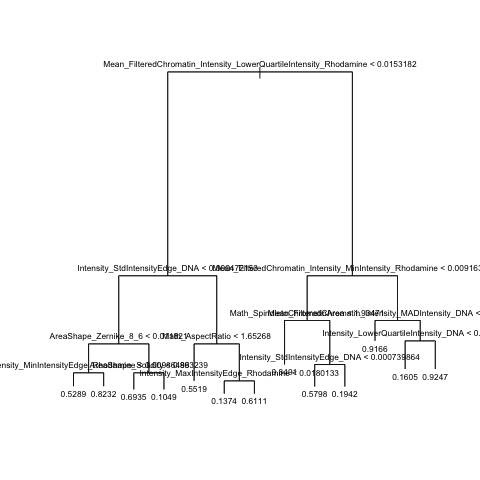

In [196]:
%%R
plot(tree.1)
text(tree.1,cex=0.7)

In [197]:
%%R
summary(tree.1)


Regression tree:
tree(formula = Y_binary ~ ., data = df_cont[, 1:166])
Variables actually used in tree construction:
 [1] "Mean_FilteredChromatin_Intensity_LowerQuartileIntensity_Rhodamine"
 [2] "Intensity_StdIntensityEdge_DNA"                                   
 [3] "AreaShape_Zernike_8_6"                                            
 [4] "Intensity_MinIntensityEdge_Rhodamine"                             
 [5] "AreaShape_Solidity"                                               
 [6] "Math_AspectRatio"                                                 
 [7] "Intensity_MaxIntensityEdge_Rhodamine"                             
 [8] "Mean_FilteredChromatin_Intensity_MinIntensity_Rhodamine"          
 [9] "Math_SpindletoChromatinArea"                                      
[10] "Mean_FilteredChromatin_Intensity_MADIntensity_DNA"                
[11] "Intensity_LowerQuartileIntensity_DNA"                             
Number of terminal nodes:  13 
Residual mean deviance:  0.1381 = 627.6 / 4543 


What if we drop Zernike moments?

In [198]:
%%R
zernike=grep('Zernike',names(df_cont),value=TRUE)
zernike
resp_w_explanatory_no_zernike=df_cont[,!names(df_cont) %in% zernike]

#names(resp_w_explanatory_no_zernike)
dim(resp_w_explanatory_no_zernike)

[1] 4556  107


In [199]:
%%R
tree.2=tree(Y_binary~., resp_w_explanatory_no_zernike[1:106])


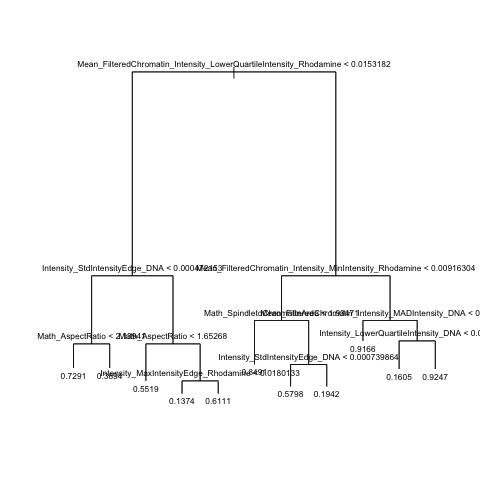

In [200]:
%%R
plot(tree.2)
text(tree.2,cex=0.7)


In [201]:
%%R
summary(tree.2)


Regression tree:
tree(formula = Y_binary ~ ., data = resp_w_explanatory_no_zernike[1:106])
Variables actually used in tree construction:
[1] "Mean_FilteredChromatin_Intensity_LowerQuartileIntensity_Rhodamine"
[2] "Intensity_StdIntensityEdge_DNA"                                   
[3] "Math_AspectRatio"                                                 
[4] "Intensity_MaxIntensityEdge_Rhodamine"                             
[5] "Mean_FilteredChromatin_Intensity_MinIntensity_Rhodamine"          
[6] "Math_SpindletoChromatinArea"                                      
[7] "Mean_FilteredChromatin_Intensity_MADIntensity_DNA"                
[8] "Intensity_LowerQuartileIntensity_DNA"                             
Number of terminal nodes:  11 
Residual mean deviance:  0.145 = 659 / 4545 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9247 -0.1374  0.0834  0.0000  0.1509  0.8626 


#Pre-processing

In [202]:
%%R
preProcPars=preProcess(df_cont_no_Y, method=c('BoxCox','center','scale'))
df_cont_no_Y_trans=predict(preProcPars, df_cont_no_Y)
#write.csv(df_cont_no_Y_trans, file='../Data/TPX2_no_Y_transf.csv')

#Predictive models

We will start from the simplest clasification model, that will take advantage from all measured features.

###a. Generalized linear models - logistic regression

You can aribtrarily start from the point below. The transformed dataset resides in the specified directory.

In [203]:
df_cont_no_Y_trans=pd.read_csv('../Data/TPX2_no_Y_transf.csv')

In [204]:
df_cont_no_Y_trans.drop('Unnamed: 0',inplace=True,axis=1)

In [205]:
print df_cont_no_Y_trans.shape

(4556, 166)


In [206]:
len(Y_binary)

4556

This is what the dataset looks like.

In [207]:
df_cont_no_Y_trans.head()

AreaShape_Area  AreaShape_Compactness  AreaShape_Eccentricity  \
0        0.748171               0.798269                0.975323   
1        0.690848               0.452047                0.765090   
2        1.001118               0.713758                0.864378   
3       -0.044863               1.234776                1.116481   
4        0.141298               0.677802                0.641837   

   AreaShape_EulerNumber  AreaShape_Extent  AreaShape_FormFactor  \
0                      0         -0.688125              0.279331   
1                      0          0.436895              0.086425   
2                      0         -0.356626             -0.256730   
3                      0         -1.400921             -0.444846   
4                      0         -1.116333             -0.319392   

   AreaShape_MajorAxisLength  AreaShape_MaxFeretDiameter  \
0                   1.081478                    1.190274   
1                   0.841052                    0.988195   
2                   1.237528                    1.164231   
3                   0.638035                    0.823417   
4                   0.414041                    0.578808   

   AreaShape_MaximumRadius  AreaShape_MeanRadius           ...            \
0                 0.388935              0.507191           ...             
1                 0.361123              0.536454           ...             
2                 0.405628              0.687159           ...             
3                -0.608125             -0.560261           ...             
4                -0.197683             -0.257739           ...             

   Mean_FilteredChromatin_Intensity_MinIntensity_Rhodamine  \
0                                          -1.284908         
1                                          -1.308978         
2                                          -1.486645         
3                                          -1.214484         
4                                          -1.245460         

   Mean_FilteredChromatin_Intensity_StdIntensityEdge_DNA  \
0                                           0.178477       
1                                          -0.541765       
2                                          -0.025550       
3                                          -0.417015       
4                                          -0.589439       

   Mean_FilteredChromatin_Intensity_StdIntensityEdge_Rhodamine  \
0                                          -0.345957             
1                                           0.356123             
2                                          -0.626586             
3                                          -0.586480             
4                                          -0.140881             

   Mean_FilteredChromatin_Intensity_StdIntensity_DNA  \
0                                          -0.877802   
1                                          -0.610002   
2                                          -0.612655   
3                                          -0.859369   
4                                          -0.703132   

   Mean_FilteredChromatin_Intensity_StdIntensity_Rhodamine  \
0                                          -0.287436         
1                                           0.823278         
2                                           0.027380         
3                                          -0.533360         
4                                          -0.035289         

   Mean_FilteredChromatin_Intensity_UpperQuartileIntensity_DNA  \
0                                          -0.761836             
1                                          -0.546560             
2                                          -0.594145             
3                                          -0.800802             
4                                          -0.694038             

   Mean_FilteredChromatin_Intensity_UpperQuartileIntensity_Rhodamine  \
0                                          -1.104058     

##Balancing dataset

Look up Ch. 16. This is the hard and forced solution.

In [208]:
df_cont_no_Y_trans['Y']=Y_binary

Below is the dataset. You can see, it's not perfectly balanced. Remember that we encoded buffer control as '0' and TPX2 add-in as '1'. 

In [209]:
df_cont_no_Y_trans.groupby('Y').count()

AreaShape_Area  AreaShape_Compactness  AreaShape_Eccentricity  \
Y                                                                  
0            1935                   1935                    1935   
1            2621                   2621                    2621   

   AreaShape_EulerNumber  AreaShape_Extent  AreaShape_FormFactor  \
Y                                                                  
0                   1935              1935                  1935   
1                   2621              2621                  2621   

   AreaShape_MajorAxisLength  AreaShape_MaxFeretDiameter  \
Y                                                          
0                       1935                        1935   
1                       2621                        2621   

   AreaShape_MaximumRadius  AreaShape_MeanRadius           ...            \
Y                                                          ...             
0                     1935                  1935           ...             
1                     2621                  2621           ...             

   Mean_FilteredChromatin_Intensity_MinIntensity_Rhodamine  \
Y                                                            
0                                               1935         
1                                               2621         

   Mean_FilteredChromatin_Intensity_StdIntensityEdge_DNA  \
Y                                                          
0                                               1935       
1                                               2621       

   Mean_FilteredChromatin_Intensity_StdIntensityEdge_Rhodamine  \
Y                                                                
0                                               1935             
1                                               2621             

   Mean_FilteredChromatin_Intensity_StdIntensity_DNA  \
Y                                                      
0                                               1935   
1                                               2621   

   Mean_FilteredChromatin_Intensity_StdIntensity_Rhodamine  \
Y                                                            
0                                               1935         
1                                               2621         

   Mean_FilteredChromatin_Intensity_UpperQuartileIntensity_DNA  \
Y                                                                
0                                               1935             
1                                               2621             

   Mean_FilteredChromatin_Intensity_UpperQuartileIntensity_Rhodamine  \
Y                                                                      
0                                               1935                   
1                                               2621                   

   Mean_FilteredChromatin_Number_Object_Number  Parent_Spindles  \
Y                                                                 
0                                         1935             1935   
1                                         2621             2621   

   Euclidian_norm_centers  
Y                          
0                    1935  
1                    2621  

[2 rows x 166 columns]

In [210]:
print df_cont_no_Y_trans[df_cont_no_Y_trans.Y==0].shape #CTRL
print df_cont_no_Y_trans[df_cont_no_Y_trans.Y==1].shape #TPX2

(1935, 167)
(2621, 167)


In [211]:
len(list(df_cont_no_Y_trans[df_cont_no_Y_trans.Y==0].index))

1935

In [212]:
indices_0=np.random.choice(a=list(df_cont_no_Y_trans[df_cont_no_Y_trans.Y==0].index), size=1900, replace=False)    

In [213]:
left_overs_0=np.setdiff1d(list(df_cont_no_Y_trans[df_cont_no_Y_trans.Y==0].index), indices_0)

In [214]:
indices_1=np.random.choice(a=list(df_cont_no_Y_trans[df_cont_no_Y_trans.Y==1].index), size=1900, replace = False)

In [215]:
left_overs_1=np.setdiff1d(list(df_cont_no_Y_trans[df_cont_no_Y_trans.Y==1].index), indices_1)

We will use the above indices to prepare training set.

In [216]:
indices_0

array([1666, 1246, 3318, ..., 1128, 4080, 1280])

In [217]:
df_cont_no_Y_trans_idx0=df_cont_no_Y_trans.iloc[indices_0,:]

In [218]:
df_cont_no_Y_trans_idx1=df_cont_no_Y_trans.iloc[indices_1,:]

In [219]:
df_cont_no_Y_trans_input=pd.concat([df_cont_no_Y_trans_idx0,df_cont_no_Y_trans_idx1])

In [220]:
df_cont_no_Y_trans_input.shape

(3800, 167)

Creating OoS dataset

In [221]:
OoS_df_cont_no_Y_trans_idx0 = df_cont_no_Y_trans.iloc[left_overs_0,:]

In [222]:
OoS_df_cont_no_Y_trans_idx1 = df_cont_no_Y_trans.iloc[left_overs_1,:]

In [223]:
OoS_df_cont_no_Y_trans_idx0.shape, OoS_df_cont_no_Y_trans_idx1.shape

((35, 167), (721, 167))

In [224]:
OoS_df_cont_no_Y_trans_input=pd.concat([OoS_df_cont_no_Y_trans_idx0, OoS_df_cont_no_Y_trans_idx1])

Let's try the basic model. We will run a grid search rightaway.

In [225]:
from sklearn.linear_model import LogisticRegression

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, ShuffleSplit

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.grid_search import GridSearchCV


In [226]:
Y=df_cont_no_Y_trans_input.iloc[:,-1]

In [227]:
X_all=df_cont_no_Y_trans_input.drop('Y',axis=1).values

In [228]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_all, Y, test_size=0.2, random_state=0)

In [229]:
X1_train.shape, X1_test.shape, Y.shape

((3040, 166), (760, 166), (3800,))

In [230]:
parameter_grid = [
  {'C': [0.1,1, 10, 100, 1000], 'penalty': ['l1']}, #lasso
  {'C': [0.1,1, 10, 100, 1000], 'penalty': ['l2']} #ridge
]


In [231]:
sklearn.utils.check_random_state(1)

In [232]:
m_LR11=GridSearchCV(estimator=LogisticRegression(),param_grid=parameter_grid,cv=5) #on MacBookAir do not change the n_jobs!

In [233]:
m_LR11.fit(X1_train, Y1_train)

GridSearchCV(cv=5,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'penalty': ['l1'], 'C': [0.1, 1, 10, 100, 1000]}, {'penalty': ['l2'], 'C': [0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [234]:
m_LR11.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)

In this case ridge performs better than lasso (worked better for mixing), but we have to use quite strong regularization.

In [332]:
X1_train.shape

(3040, 166)

In [235]:
print m_LR11.best_score_
print m_LR11.score(X1_test,Y1_test)

0.882236842105
0.864473684211


Also, as we could already see on data projection, we cannot separate the classes as well as in the mixing experiments.

Let's evaluate this model.

In [236]:
def plot_roc_curve(target_test, target_predicted_proba):
    '''If your labels are not binary, they will be converted to 0,1, which is required by roc_curve()'''

    try:
        fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    except ValueError:
        mapper=dict(zip(np.unique(target_test),range(np.shape(np.unique(target_test))[0])))
        new_target_test=map(lambda x: mapper[x],target_test)
        fpr, tpr, thresholds = roc_curve(new_target_test, target_predicted_proba[:, 1])
        
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.legend(loc="lower right")
    
    #Infer Youden index
    sensitivity=tpr
    specificity=1-fpr
    J=sensitivity + specificity -1
    plt.annotate('Youden index', xy=(fpr[np.where(J==max(J))],tpr[np.where(J==max(J))]),xytext=(fpr[np.where(J==max(J))]+0.15,tpr[np.where(J==max(J))]-0.05),arrowprops=dict(facecolor='red', shrink=0.1, width=2, frac=0.3, headwidth=8),color='r')
    
    print 'optimal probability threshold: ', thresholds[np.where(J==max(J))]

    print 'fpr: ',fpr[np.where(J==max(J))]
    print 'tpr: ',tpr[np.where(J==max(J))]



optimal probability threshold:  [ 0.46320047]
fpr:  [ 0.13953488]
tpr:  [ 0.8766756]


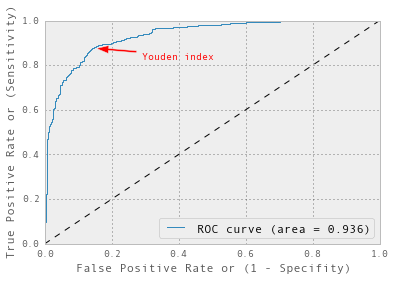

In [237]:
Y_pred_LR11_probs=m_LR11.predict_proba(X1_test)
plot_roc_curve(Y1_test,Y_pred_LR11_probs)

#plt.savefig('../Plots/TPX2_trained_ROC_LR11.pdf')

In [238]:
Y_pred_LR11 = m_LR11.predict(X1_test)

In [239]:
print classification_report(Y1_test,Y_pred_LR11)

             precision    recall  f1-score   support

          0       0.87      0.86      0.87       387
          1       0.86      0.87      0.86       373

avg / total       0.86      0.86      0.86       760



[[334  53]
 [ 50 323]]
760
373
0.863049095607
0.865951742627
Normalized confusion matrix
[[ 0.8630491   0.1369509 ]
 [ 0.13404826  0.86595174]]


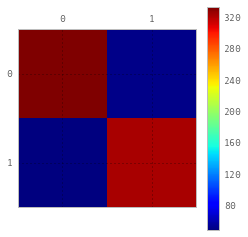

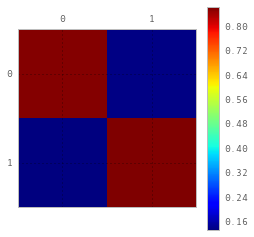

In [240]:
cm_LR11=confusion_matrix(Y1_test, Y_pred_LR11)

print(cm_LR11)

plt.matshow(cm_LR11)
#plt.title('Confusion matrix')
plt.colorbar()

print len(Y1_test) #all 
print np.sum(Y1_test) #STG8

print float(cm_LR11[0][0])/(len(Y1_test)-np.sum(Y1_test)) #00 CTRL
print float(cm_LR11[1][1])/(np.sum(Y1_test)) #11 TPX2

cm_normalized = cm_LR11.astype('float') / cm_LR11.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)

plt.matshow(cm_normalized)
plt.colorbar()


plt.savefig('../Plots/TPX2_trained_cm_LR11_corr.pdf')

Test on OoS

In [241]:
#OoS_df_cont_no_Y_trans_input.shape, OoS_df_cont_no_Y_trans_input.iloc[:, 167-1], OoS_df_cont_no_Y_trans_input.iloc[:, 0:167-1]

[[ 32   3]
 [ 81 640]]
756
721
Accuracy: CTRL
0.914285714286
Accuracy: TPX2
0.887656033287


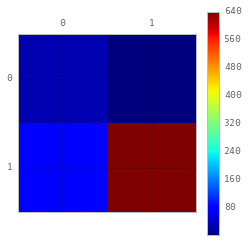

In [242]:
cm_LR11_OoS=confusion_matrix(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values, m_LR11.predict(OoS_df_cont_no_Y_trans_input.iloc[:, 0:167-1].values))

print(cm_LR11_OoS)

plt.matshow(cm_LR11_OoS)
#plt.title('Confusion matrix')
plt.colorbar()

print len(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values) #len(Y1_test) #all 
print np.sum(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values) #np.sum(Y1_test) #STG8

print 'Accuracy: CTRL'
print float(cm_LR11_OoS[0][0])/(len(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values)-np.sum(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values)) #00 CTRL
print 'Accuracy: TPX2'
print float(cm_LR11_OoS[1][1])/(np.sum(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values)) #11 TPX2


#plt.savefig('../Plots/TPX2_trained_cm_LR11.pdf')

Let's try a non-linear classifier.

In [243]:
from sklearn import svm

In [244]:
parameter_grid_svm = [
 {'C': [0.01,0.1,1, 10, 100, 1000, 3000, 10000], 'gamma': [0.1,0.01,0.001, 0.0001,0.0003], 'kernel': ['rbf']}
 ]

In [245]:
m_svm11=GridSearchCV(svm.SVC(),parameter_grid_svm,cv=5,n_jobs=2) #seems like svm can handle it

In [246]:
m_svm11.fit(X1_train,Y1_train)

GridSearchCV(cv=5,
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=2,
       param_grid=[{'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100, 1000, 3000, 10000], 'gamma': [0.1, 0.01, 0.001, 0.0001, 0.0003]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [247]:
m_svm11.best_estimator_

SVC(C=3000, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.0001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [248]:
m_svm11.best_score_

0.90131578947368418

Not that much better than the logistic regression.

In [249]:
 Y_pred_svm11 = m_svm11.predict(X1_test)

[[344  43]
 [ 51 322]]
760
373
0.888888888889
0.86327077748
Normalized confusion matrix
[[ 0.88888889  0.11111111]
 [ 0.13672922  0.86327078]]


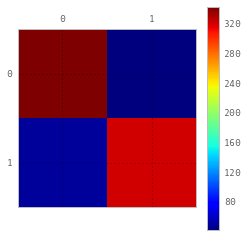

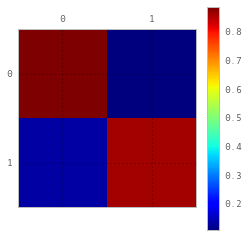

In [250]:
cm_svm11=confusion_matrix(Y1_test, Y_pred_svm11)

print(cm_svm11)

plt.matshow(cm_svm11)
#plt.title('Confusion matrix')
plt.colorbar()

print len(Y1_test) #all 
print np.sum(Y1_test) #STG8

print float(cm_svm11[0][0])/(len(Y1_test)-np.sum(Y1_test)) #00 CTRL
print float(cm_svm11[1][1])/(np.sum(Y1_test)) #11 TPX2

cm_normalized = cm_svm11.astype('float') / cm_svm11.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)

plt.matshow(cm_normalized)
plt.colorbar()

plt.savefig('../Plots/TPX2_trained_cm_svm11_corr.pdf')

In [251]:
print classification_report(Y1_test,Y_pred_svm11)

             precision    recall  f1-score   support

          0       0.87      0.89      0.88       387
          1       0.88      0.86      0.87       373

avg / total       0.88      0.88      0.88       760



Test on out-of-sample set. This test is strongly unbalanced, but this should not be a problem if training and tuning worked well.

[[ 33   2]
 [ 76 645]]
756
721
Accuracy: CTRL
0.942857142857
Accuracy: TPX2
0.894590846047
Normalized confusion matrix
[[ 0.94285714  0.05714286]
 [ 0.10540915  0.89459085]]


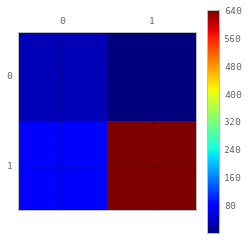

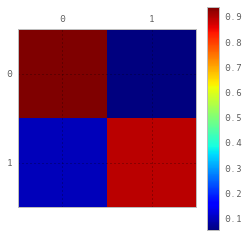

In [252]:
cm_svm11_OoS=confusion_matrix(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values, m_svm11.predict(OoS_df_cont_no_Y_trans_input.iloc[:, 0:167-1].values))

print(cm_svm11_OoS)

plt.matshow(cm_svm11_OoS)
#plt.title('Confusion matrix')
plt.colorbar()

print len(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values) #len(Y1_test) #all 
print np.sum(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values) #np.sum(Y1_test) #STG8

print 'Accuracy: CTRL'
print float(cm_svm11_OoS[0][0])/(len(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values)-np.sum(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values)) #00 CTRL
print 'Accuracy: TPX2'
print float(cm_svm11_OoS[1][1])/(np.sum(OoS_df_cont_no_Y_trans_input.iloc[:, 167-1].values)) #11 TPX2

cm_normalized = cm_svm11_OoS.astype('float') / cm_svm11_OoS.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)

plt.matshow(cm_normalized)
plt.colorbar()


plt.savefig('../Plots/TPX2_trained_OoS_cm_LR11_corr.pdf')

One more non-linear classifier

In [253]:
from sklearn.ensemble import ExtraTreesClassifier

In [254]:
m_tree11 = ExtraTreesClassifier().fit(X1_train, Y1_train)

In [255]:
accuracy_score(Y1_test, m_tree11.predict(X1_test))

0.80657894736842106

In [256]:
print classification_report(Y1_test, m_tree11.predict(X1_test))

             precision    recall  f1-score   support

          0       0.79      0.84      0.82       387
          1       0.83      0.77      0.80       373

avg / total       0.81      0.81      0.81       760



####Applying PCA

In [257]:
%%R 
names(df_cont_no_Y_trans)

#apply(df_cont_no_Y_trans, 2, var, na.rm=TRUE)
names(apply(df_cont_no_Y_trans, 2, var, na.rm=TRUE)[which(apply(df_cont_no_Y_trans, 2, var, na.rm=TRUE)==0)])
df_cont_no_Y_trans_no_null_var=df_cont_no_Y_trans[,names(apply(df_cont_no_Y_trans, 2, var, na.rm=TRUE)[which(apply(df_cont_no_Y_trans, 2, var, na.rm=TRUE)!=0)])]


In [258]:
%%R
dim(df_cont_no_Y_trans_no_null_var)

[1] 4556  165


In [259]:
%%R 
df_cont_no_Y_trans_no_null_var.pca=prcomp(df_cont_no_Y_trans_no_null_var, center = TRUE, scale=TRUE)


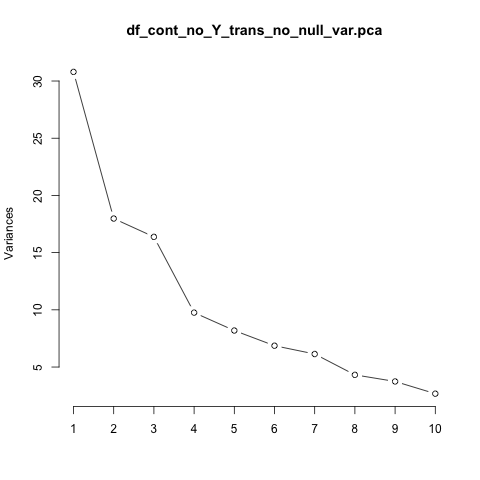

In [260]:
%%R
plot(df_cont_no_Y_trans_no_null_var.pca, type='l')


In factor.scores, the correlation matrix is singular, an approximation is used


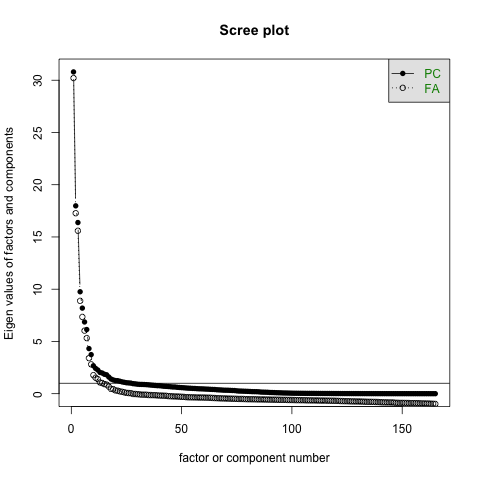

In [261]:
%%R
scree(df_cont_no_Y_trans_no_null_var)

In factor.scores, the correlation matrix is singular, an approximation is used
Parallel analysis suggests that the number of factors =  21  and the number of components =  20 


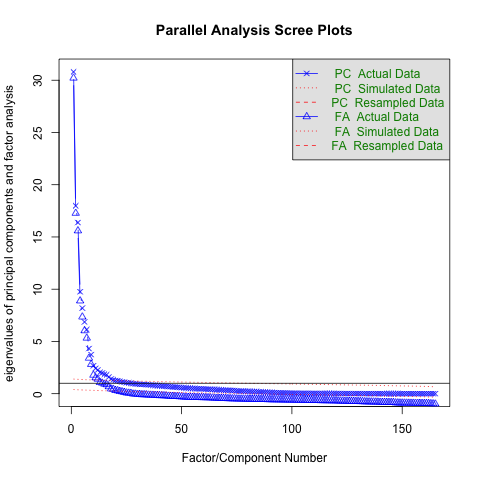

In [262]:
%%R 
library(psych)

res = fa.parallel(df_cont_no_Y_trans_no_null_var)


In [263]:
%%R

library(caret)
#names(df_cont_no_Y_trans_no_null_var)
params.pca=preProcess(df_cont_no_Y_trans_no_null_var, method='pca')
df_cont_no_Y_trans_no_null_var_PCA=predict(params.pca, df_cont_no_Y_trans_no_null_var)

dim(df_cont_no_Y_trans_no_null_var_PCA)

[1] 4556   64


In [264]:
%%R
params.pca


Call:
preProcess.default(x = df_cont_no_Y_trans_no_null_var, method = "pca")

Created from 4556 samples and 165 variables
Pre-processing: principal component signal extraction, scaled, centered 

PCA needed 64 components to capture 95 percent of the variance


**Caret uses 95% variance cutoff.**

In [265]:
%%R
df_cont_no_Y_trans_no_null_var_PCA.2.params = prcomp(df_cont_no_Y_trans_no_null_var, center = TRUE, scale=TRUE )

In [266]:
%%R
df_cont_no_Y_trans_no_null_var_PCA.2 = predict(df_cont_no_Y_trans_no_null_var_PCA.2.params, newdata=df_cont_no_Y_trans_no_null_var)

In [267]:
%%R
print(df_cont_no_Y_trans_no_null_var_PCA[1:3, 1:4])
print(df_cont_no_Y_trans_no_null_var_PCA.2[1:3, 1:4])

#write.csv(df_cont_no_Y_trans_no_null_var_PCA,'../Data/TPX2/TPX2_df_cont_no_Y_trans_no_null_var_PCA.csv')

         PC1       PC2       PC3       PC4
0  2.1272534 0.6235951  8.658186 -4.542924
1 -0.2529006 2.6731737  5.624887 -6.744884
2 -2.1261839 2.2080084 10.701600 -5.778965
         PC1       PC2       PC3       PC4
0  2.1272534 0.6235951  8.658186 -4.542924
1 -0.2529006 2.6731737  5.624887 -6.744884
2 -2.1261839 2.2080084 10.701600 -5.778965


Excellent. Transformation gives expected results. We'll save the transformed dataset and use it for training.

In [268]:
%%R
print(summary(df_cont_no_Y_trans_no_null_var_PCA.2.params))

Importance of components:
                          PC1    PC2     PC3     PC4     PC5    PC6     PC7
Standard deviation     5.5494 4.2400 4.04696 3.12335 2.86182 2.6200 2.47773
Proportion of Variance 0.1866 0.1090 0.09926 0.05912 0.04964 0.0416 0.03721
Cumulative Proportion  0.1866 0.2956 0.39486 0.45398 0.50362 0.5452 0.58242
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     2.07770 1.93357 1.63412 1.55630 1.50508 1.42629 1.40615
Proportion of Variance 0.02616 0.02266 0.01618 0.01468 0.01373 0.01233 0.01198
Cumulative Proportion  0.60859 0.63125 0.64743 0.66211 0.67584 0.68817 0.70015
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     1.36382 1.34448 1.26274 1.18534 1.14711 1.12105 1.11524
Proportion of Variance 0.01127 0.01096 0.00966 0.00852 0.00797 0.00762 0.00754
Cumulative Proportion  0.71142 0.72238 0.73204 0.74056 0.74853 0.75615 0.76369
                          PC22    PC23

Loading required package: plyr

Attaching package: ‘plyr’

The following objects are masked from ‘package:reshape’:

    rename, round_any

The following objects are masked from ‘package:Hmisc’:

    is.discrete, summarize

Loading required package: scales

Attaching package: ‘scales’

The following objects are masked from ‘package:psych’:

    alpha, rescale



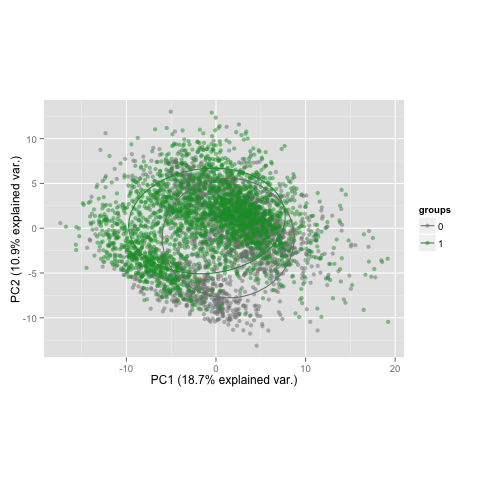

In [269]:
%%R
library(ggbiplot)

ggbiplot(df_cont_no_Y_trans_no_null_var.pca, obs.scale = 1, var.scale = 1, groups=as.character(Y_binary), ellipse=TRUE, circle=FALSE, var.axes=FALSE, ellipse.prob = 0.68, varname.abbrev=TRUE, varname.size = 0, alpha=0.5)+scale_color_manual(values=c('#7F7F7F','#179B33'))


PCA on selected variables.

In [270]:
%%R
filter_vars_ANOVA = read.csv('../Data/TPX2_features_ANOVA_BONF_sel_005.csv',header = FALSE, stringsAsFactors=FALSE)
filter_vars_ANOVA = filter_vars_ANOVA[2:96,2]



In [271]:
%%R

names(df_cont_no_Y_trans_no_null_var) %in% filter_vars_ANOVA
df_cont_no_Y_trans_no_null_var_ANOVA = df_cont_no_Y_trans_no_null_var[,names(df_cont_no_Y_trans_no_null_var) %in% filter_vars_ANOVA]
df_cont_no_Y_trans_no_null_var_PCA.3.params = prcomp(df_cont_no_Y_trans_no_null_var_ANOVA, center = TRUE, scale=TRUE )

In [272]:
%%R
#save(df_cont_no_Y_trans_no_null_var_PCA.3.params,Y_binary,  file = '../Data/TPX2_features_PCA.Robj')

NULL


In [273]:
%%R
summary(df_cont_no_Y_trans_no_null_var_PCA.3.params )

Importance of components:
                          PC1    PC2    PC3     PC4    PC5     PC6     PC7
Standard deviation     4.8423 3.4372 3.2017 2.49664 2.4562 2.13666 2.01665
Proportion of Variance 0.2468 0.1244 0.1079 0.06561 0.0635 0.04806 0.04281
Cumulative Proportion  0.2468 0.3712 0.4791 0.54470 0.6082 0.65626 0.69907
                           PC8     PC9    PC10    PC11   PC12    PC13   PC14
Standard deviation     1.69799 1.52391 1.34685 1.33147 1.2292 1.12436 1.0983
Proportion of Variance 0.03035 0.02445 0.01909 0.01866 0.0159 0.01331 0.0127
Cumulative Proportion  0.72942 0.75386 0.77296 0.79162 0.8075 0.82083 0.8335
                         PC15    PC16    PC17   PC18    PC19    PC20    PC21
Standard deviation     1.0939 0.99790 0.96886 0.9245 0.87313 0.86467 0.82865
Proportion of Variance 0.0126 0.01048 0.00988 0.0090 0.00802 0.00787 0.00723
Cumulative Proportion  0.8461 0.85661 0.86649 0.8755 0.88351 0.89138 0.89861
                          PC22    PC23    PC24    PC25    

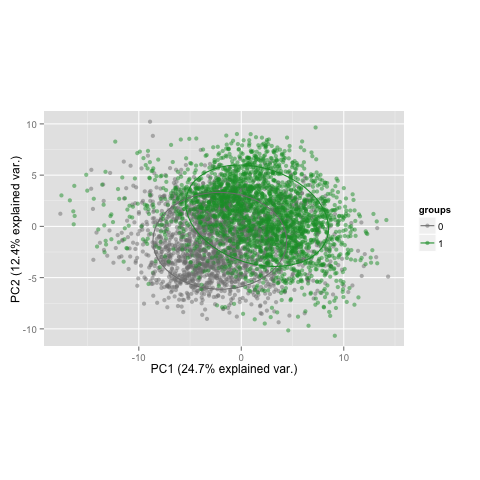

In [274]:
%%R
library(ggbiplot)

ggbiplot(df_cont_no_Y_trans_no_null_var_PCA.3.params , obs.scale = 1, var.scale = 1, groups=as.character(Y_binary), ellipse=TRUE, circle=FALSE, var.axes=FALSE, ellipse.prob = 0.68, varname.abbrev=TRUE, varname.size = 0, alpha=0.5)+scale_color_manual(values=c('#7F7F7F','#179B33'))



In [275]:
%%R
dim(df_cont_no_Y_trans_no_null_var_PCA.3.params$rotation)

[1] 95 95


Let's try the logistic regression 

In [276]:
df_cont_no_Y_trans_no_null_var_PCA = pd.read_csv('../Data/TPX2/TPX2_df_cont_no_Y_trans_no_null_var_PCA.csv')
df_cont_no_Y_trans_no_null_var_PCA.drop('Unnamed: 0', axis=1, inplace=True)

In [277]:
X2_idx0=df_cont_no_Y_trans_no_null_var_PCA.iloc[indices_0,:]
X2_idx1=df_cont_no_Y_trans_no_null_var_PCA.iloc[indices_1,:]
X2_all=pd.concat([X2_idx0, X2_idx1])

In [278]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2_all.values, Y, test_size=0.2, random_state=0)

parameter_grid = [
  {'C': [0.1,1, 10, 100, 1000], 'penalty': ['l1']}, #lasso
  {'C': [0.1,1, 10, 100, 1000], 'penalty': ['l2']} #ridge
]

m_LR21=GridSearchCV(estimator=LogisticRegression(),param_grid=parameter_grid,cv=5) #on MacBookAir do not change the n_jobs!

In [279]:
m_LR21.fit(X2_train, Y2_train)

GridSearchCV(cv=5,
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'penalty': ['l1'], 'C': [0.1, 1, 10, 100, 1000]}, {'penalty': ['l2'], 'C': [0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [280]:
m_LR21.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)

In [281]:
m_LR21.best_score_

0.84703947368421051

Looks like it's actually worse?

In [282]:
print classification_report(Y2_test,m_LR21.predict(X2_test))

             precision    recall  f1-score   support

          0       0.82      0.83      0.82       387
          1       0.82      0.81      0.81       373

avg / total       0.82      0.82      0.82       760



[[320  67]
 [ 71 302]]
760
373
0.826873385013
0.809651474531


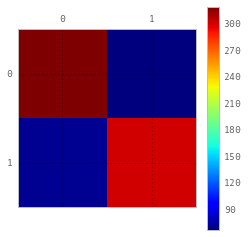

In [283]:
cm_LR21=confusion_matrix(Y2_test, m_LR21.predict(X2_test))

print(cm_LR21)

plt.matshow(cm_LR21)
#plt.title('Confusion matrix')
plt.colorbar()

print len(Y2_test) #all 
print np.sum(Y2_test) #STG8

print float(cm_LR21[0][0])/(len(Y2_test)-np.sum(Y2_test)) #00 CTRL
print float(cm_LR21[1][1])/(np.sum(Y2_test)) #11 TPX2




#plt.savefig('../Plots/TPX2_PCA_trained_cm_svm11.pdf')

Looks like this approach is performing worse than original one (no dimensionality reduction).  

Let's try the SVM.

In [284]:
parameter_grid_svm = [
 {'C': [0.01,0.1,1, 10, 100, 1000, 3000, 10000], 'gamma': [0.1,0.01,0.001, 0.0001,0.0003], 'kernel': ['rbf']}
 ]

In [285]:
m_svm21=GridSearchCV(svm.SVC(),parameter_grid_svm,cv=5,n_jobs=2) #seems like svm can handle it

In [286]:
m_svm21.fit(X2_train, Y2_train)

GridSearchCV(cv=5,
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=2,
       param_grid=[{'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100, 1000, 3000, 10000], 'gamma': [0.1, 0.01, 0.001, 0.0001, 0.0003]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [287]:
m_svm21.best_score_

0.88256578947368425

In [288]:
m_svm21.best_estimator_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.01,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [289]:
print classification_report(Y2_test,m_svm21.predict(X2_test))

             precision    recall  f1-score   support

          0       0.85      0.89      0.87       387
          1       0.88      0.83      0.85       373

avg / total       0.86      0.86      0.86       760



[[343  44]
 [ 62 311]]
760
373
0.886304909561
0.833780160858
Normalized confusion matrix
[[ 0.88630491  0.11369509]
 [ 0.16621984  0.83378016]]


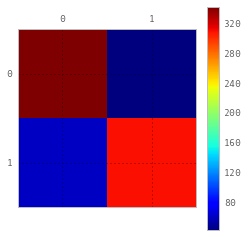

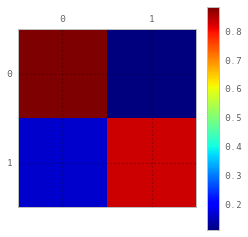

In [290]:
cm_svm21=confusion_matrix(Y2_test, m_svm21.predict(X2_test))

print(cm_svm21)

plt.matshow(cm_svm21)
#plt.title('Confusion matrix')
plt.colorbar()

print len(Y2_test) #all 
print np.sum(Y2_test) #STG8

print float(cm_svm21[0][0])/(len(Y2_test)-np.sum(Y2_test)) #00 CTRL
print float(cm_svm21[1][1])/(np.sum(Y2_test)) #11 TPX2

cm_normalized = cm_svm21.astype('float') / cm_svm21.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)

plt.matshow(cm_normalized)
plt.colorbar()





plt.savefig('../Plots/TPX2_PCA_trained_cm_svm21_corr.pdf')

To use the PCA approach. You will need to drop the Euler number variable, use the rotations from above derived parameters, and then, use the model above. 

# Feature selection
There are several ways to select best features. One thing that one has to take into consideration is a phenomenon called multicollinearity, in which we have near linear relationships in explanatory variables, which leads to unstable parameter estimates. It may not necessarily affect accuracy of a predictive model, but it will affect analysis of the features that contribute to its performance (we will compare that). We would like to identify these variables, as, scientifically, we might actually be interested in these correlations (although some may be a result of mathematical necessity). The added benefit is that, once we know them, we can take care of them before we run a classification algorithm.      
       
Some of the options one can consider: 
* removing features with lowest variance     
* performing feature selection based on the value of variance inflation factor (for regression)   
* selecting variables based on weights in classification model(L1, LASSO)
* univariate feature selection: Kruskall-Wallis / KS / one-way ANOVA /t-test
* binary recursive tree models
* factor analysis (classification of variables)
* stepwise discriminant analysis
* sequential forward search (SFS)
* sequential floating forward search (SFFS)
* classifier supported recursive feature elimination 
* recursive feature elimination
* genetic algorithms
* simulated annealing


##Filter methods

###Basic feature selection - univariate

####1. Using ANOVA      
Assumes normal distribution.

In [291]:
a1=np.array(sklearn.feature_selection.univariate_selection.f_classif(X1_train,Y1_train)[1])
b1=np.array(df_cont_no_Y_trans.columns.tolist())
    
idx1=a1.argsort()

b1_sorted=b1[idx1]
a1_sorted=a1[idx1]

In [292]:
idx=1
for name, p_val in zip(b1_sorted,a1_sorted):
    if re.match('.*DNA.*',name) != None:
        print idx, 'DNA\t', re.match('.*DNA.*',name).group(0), '\t', p_val
    elif re.match('.*chromatin.*',name, flags=re.IGNORECASE) != None:
        print idx, 'chromatin\t', re.match('.*chromatin.*',name, flags=re.IGNORECASE).group(0), '\t', p_val
    else: 
        print idx, 'OTHER\t', name, '\t', p_val
    idx+=1

1 chromatin	Mean_FilteredChromatin_Intensity_MinIntensity_Rhodamine 	6.02211496926e-161
2 chromatin	Mean_FilteredChromatin_Intensity_MinIntensityEdge_Rhodamine 	7.10253439202e-157
3 OTHER	AreaShape_Zernike_0_0 	1.63792380498e-147
4 OTHER	Math_AspectRatio 	6.96159994916e-145
5 chromatin	Mean_FilteredChromatin_Intensity_LowerQuartileIntensity_Rhodamine 	2.27264673649e-127
6 DNA	Intensity_StdIntensityEdge_DNA 	6.38718506895e-123
7 chromatin	Mean_FilteredChromatin_Intensity_MeanIntensityEdge_Rhodamine 	1.31410785047e-121
8 OTHER	Intensity_MaxIntensity_Rhodamine 	6.09623901305e-121
9 OTHER	AreaShape_Zernike_8_6 	3.22722673294e-120
10 OTHER	Intensity_MinIntensity_Rhodamine 	5.6747967957e-109
11 chromatin	Mean_FilteredChromatin_Intensity_MeanIntensity_Rhodamine 	3.29915024818e-108
12 OTHER	AreaShape_Eccentricity 	4.48643619704e-106
13 OTHER	AreaShape_Zernike_6_4 	5.24004413814e-106
14 OTHER	Intensity_MinIntensityEdge_Rhodamine 	6.2038043972e-105
15 DNA	Intensity_MaxIntensityEdge_DNA 	8.804718

Corrected:

In [293]:
results_ANOVA = zip(b1_sorted,a1_sorted)
results_ANOVA = np.array(results_ANOVA)

In [294]:
%R -i results_ANOVA

In [295]:
%%R
dim(results_ANOVA)
class(results_ANOVA)

names.ANOVA = results_ANOVA[,1]
values.ANOVA = as.numeric(as.vector(results_ANOVA[,2]))

names(values.ANOVA) = names.ANOVA

values.ANOVA.bonf = p.adjust(values.ANOVA, method = "bonferroni")
print(as.numeric(values.ANOVA)[1:10])
print(p.adjust(as.numeric(values.ANOVA), method = "bonferroni")[1:10])

print(sort(values.ANOVA.bonf))
#print(sort(values.ANOVA))
#print(values.ANOVA.bonf<=0.05)

length(values.ANOVA.bonf[which(values.ANOVA.bonf<=0.05)]) #95
length(values.ANOVA.bonf[which(values.ANOVA.bonf<=0.01)]) #91
length(values.ANOVA.bonf[which(values.ANOVA.bonf<=0.001)]) #88

filter_vars_ANOVA = names(values.ANOVA.bonf[which(values.ANOVA.bonf<=0.05)])
#write.csv(as.data.frame(sort(values.ANOVA.bonf)), '../Data/TPX2_features_ANOVA_BONF_rank.csv')
#write.csv(filter_vars_ANOVA, '../Data/TPX2_features_ANOVA_BONF_sel_005.csv')


 [1] 6.022115e-161 7.102534e-157 1.637924e-147 6.961600e-145 2.272647e-127
 [6] 6.387185e-123 1.314108e-121 6.096239e-121 3.227227e-120 5.674797e-109
 [1] 9.936490e-159 1.171918e-154 2.702574e-145 1.148664e-142 3.749867e-125
 [6] 1.053886e-120 2.168278e-119 1.005879e-118 5.324924e-118 9.363415e-107
           Mean_FilteredChromatin_Intensity_MinIntensity_Rhodamine 
                                                     9.936490e-159 
       Mean_FilteredChromatin_Intensity_MinIntensityEdge_Rhodamine 
                                                     1.171918e-154 
                                             AreaShape_Zernike_0_0 
                                                     2.702574e-145 
                                                  Math_AspectRatio 
                                                     1.148664e-142 
 Mean_FilteredChromatin_Intensity_LowerQuartileIntensity_Rhodamine 
                                                     3.749867e-125 
                    

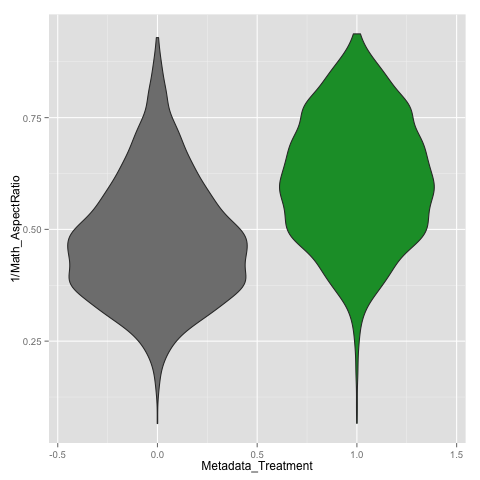

In [296]:
%%R
#5
plot.1=ggplot()
plot.1 = plot.1+geom_violin(data=df_cont,aes(x=Metadata_Treatment,y=1/Math_AspectRatio ,fill=factor(Metadata_Treatment)))
plot.1+theme(legend.position='none')+scale_fill_manual(values=c('#7F7F7F','#179B33'))
#ggsave('../Plots/TPX2_violin_Math_AspectRatio_5.pdf')


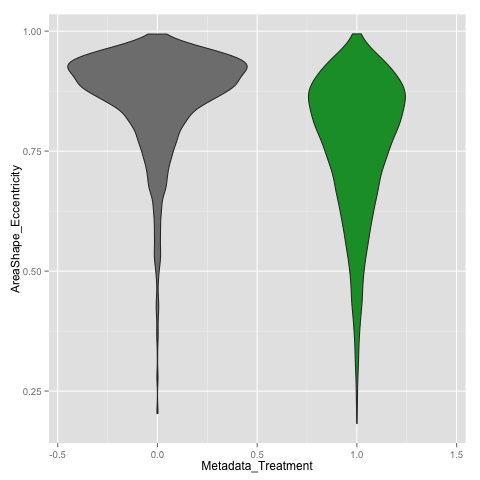

In [297]:
%%R
#13
plot.1=ggplot()
plot.1 = plot.1+geom_violin(data=df_cont,aes(x=Metadata_Treatment,y=AreaShape_Eccentricity ,fill=factor(Metadata_Treatment)))
plot.1+theme(legend.position='none')+scale_fill_manual(values=c('#7F7F7F','#179B33'))
#ggsave('../Plots/TPX2_violin_AreaShape_Eccentricity_13.pdf')



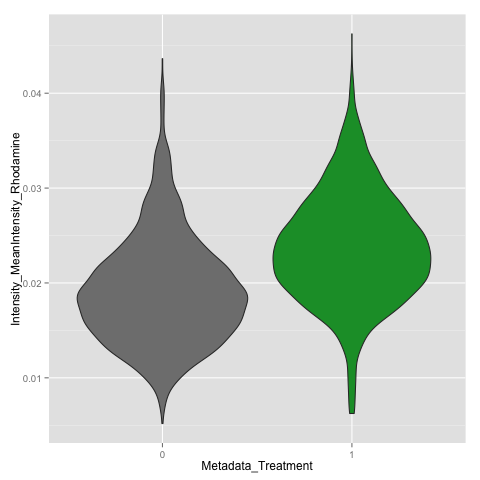

In [298]:
%%R
#15
library(ggplot2)
df_cont$Metadata_Treatment = as.factor(df_cont$Metadata_Treatment)

plot.1=ggplot()

#factor_order=c(800, 890, 875, 850)

plot.1 = plot.1+geom_violin(data=df_cont,aes(x=Metadata_Treatment,y=Intensity_MeanIntensity_Rhodamine,fill=factor(Metadata_Treatment)))
#plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))

#plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF') & (CSF_STG8$Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA<0.06),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA,fill=factor(Metadata_Type)))


#plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MedianIntensity_DNA,fill=factor(Metadata_Type)))
#plot=plot+scale_fill_manual(values=c('#E30D16','#815C5D','#9F4448', '#C6252B','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot.1+theme(legend.position='none')+scale_fill_manual(values=c('#7F7F7F','#179B33'))
#ggsave('../Plots/TPX2_violin_Intensity_MeanIntensity_Rhodamine_15.pdf')

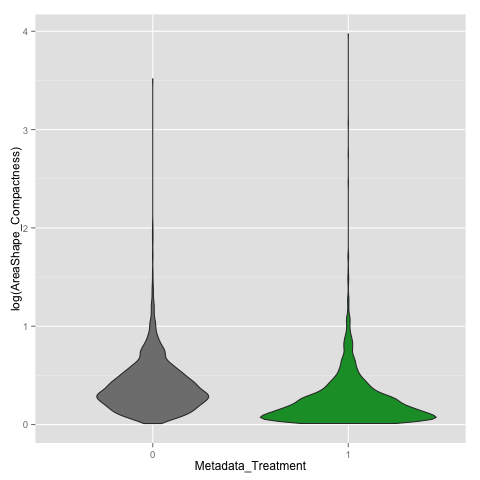

In [299]:
%%R
#20
plot.1=ggplot()
plot.1 = plot.1+geom_violin(data=df_cont,aes(x=Metadata_Treatment,y=log(AreaShape_Compactness),fill=factor(Metadata_Treatment)))
plot.1+theme(legend.position='none')+scale_fill_manual(values=c('#7F7F7F','#179B33'))
#ggsave('../Plots/TPX2_violin_log_AreaShape_Compactness_20.pdf')




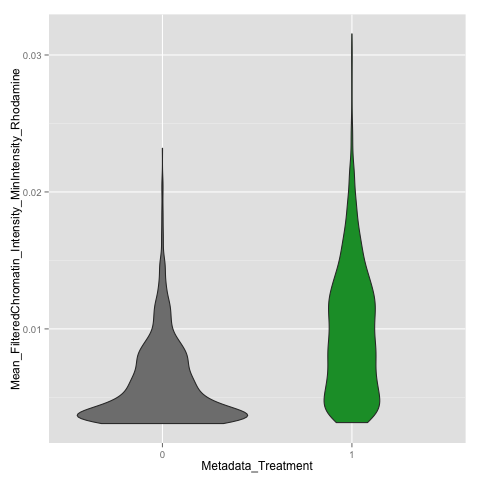

In [300]:
%%R
df_cont$Metadata_Treatment = as.factor(df_cont$Metadata_Treatment)

plot=ggplot()

#factor_order=c(800, 890, 875, 850)

plot = plot+geom_violin(data=df_cont,aes(x=Metadata_Treatment,y=Mean_FilteredChromatin_Intensity_MinIntensity_Rhodamine,fill=factor(Metadata_Treatment)))
#plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))

#plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF') & (CSF_STG8$Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA<0.06),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA,fill=factor(Metadata_Type)))


#plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MedianIntensity_DNA,fill=factor(Metadata_Type)))
#plot=plot+scale_fill_manual(values=c('#E30D16','#815C5D','#9F4448', '#C6252B','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot+theme(legend.position='none')+scale_fill_manual(values=c('#7F7F7F','#179B33'))
#ggsave('../Plots/mixing_violin_Mean_FilteredChromatin_Intensity_MedianIntensity_DNA_5.pdf')

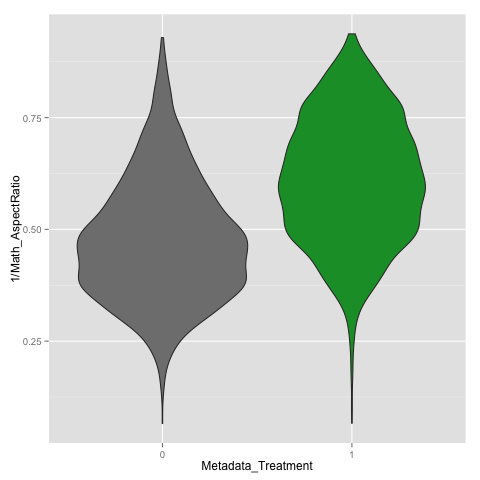

In [301]:
%%R
df_cont$Metadata_Treatment = as.factor(df_cont$Metadata_Treatment)

plot=ggplot()

#factor_order=c(800, 890, 875, 850)

plot = plot+geom_violin(data=df_cont,aes(x=Metadata_Treatment,y=1/Math_AspectRatio,fill=factor(Metadata_Treatment)))
#plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))

#plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF') & (CSF_STG8$Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA<0.06),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA,fill=factor(Metadata_Type)))


#plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MedianIntensity_DNA,fill=factor(Metadata_Type)))
#plot=plot+scale_fill_manual(values=c('#E30D16','#815C5D','#9F4448', '#C6252B','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot+theme(legend.position='none')+scale_fill_manual(values=c('#7F7F7F','#179B33'))
#ggsave('../Plots/mixing_violin_Mean_FilteredChromatin_Intensity_MedianIntensity_DNA_5.pdf')

**Predictive models on filtered dataset.**

In [302]:
filter_vars_ANOVA = pd.read_csv('../Data/TPX2_features_ANOVA_BONF_sel_005.csv', header=None)

In [303]:
filter_vars_ANOVA = filter_vars_ANOVA.iloc[1:,1].tolist()

In [304]:
df_cont_no_Y_trans_input[filter_vars_ANOVA].shape

(3800, 95)

In [305]:
df_cont_no_Y_trans_input_ANOVA=df_cont_no_Y_trans_input[filter_vars_ANOVA]

In [306]:
X_A = df_cont_no_Y_trans_input_ANOVA.values

In [307]:
XA_train, XA_test, YA_train, YA_test = train_test_split(X_A, Y, test_size=0.2, random_state=0)

In [308]:
parameter_grid_svm = [
 {'C': [0.01,0.1,1, 10, 100, 1000, 3000, 10000], 'gamma': [0.1,0.01,0.001, 0.0001,0.0003], 'kernel': ['rbf']}
 ]

In [309]:
m_svm31=GridSearchCV(svm.SVC(),parameter_grid_svm,cv=5,n_jobs=2) #seems like svm can handle it

In [310]:
m_svm31.fit(XA_train, YA_train)

GridSearchCV(cv=5,
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=2,
       param_grid=[{'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100, 1000, 3000, 10000], 'gamma': [0.1, 0.01, 0.001, 0.0001, 0.0003]}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [311]:
m_svm31.best_score_

0.90098684210526314

[[349  38]
 [ 58 315]]
760
373
0.90180878553
0.844504021448
Normalized confusion matrix
[[ 0.90180879  0.09819121]
 [ 0.15549598  0.84450402]]


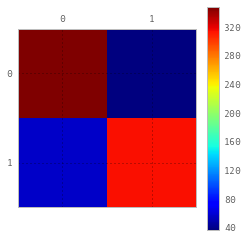

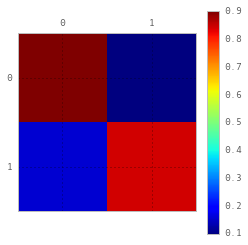

In [312]:
cm_svm31=confusion_matrix(YA_test, m_svm31.predict(XA_test))

print(cm_svm31)

plt.matshow(cm_svm31)
#plt.title('Confusion matrix')
plt.colorbar()

print len(YA_test) #all 
print np.sum(YA_test) #STG8

print float(cm_svm31[0][0])/(len(YA_test)-np.sum(YA_test)) #00 CTRL
print float(cm_svm31[1][1])/(np.sum(YA_test)) #11 TPX2

cm_normalized = cm_svm31.astype('float') / cm_svm31.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)

plt.matshow(cm_normalized)
plt.colorbar()



plt.savefig('../Plots/TPX2_FEAT_SEL_trained_cm_svm31_corr.pdf')

In [313]:
print classification_report(YA_test, m_svm31.predict(XA_test))

             precision    recall  f1-score   support

          0       0.86      0.90      0.88       387
          1       0.89      0.84      0.87       373

avg / total       0.87      0.87      0.87       760



####2. Using [Kruskal-Wallis](http://www.r-tutor.com/elementary-statistics/non-parametric-methods/kruskal-wallis-test)      
Makes no assumptions about distribution. One-way ANOVA equivalent if normality requirement is not satisfied. Perform on non-transformed data.

In [314]:
%%R 
print(dim(df_cont_no_Y_trans))
print(dim(Y_binary))

print(kruskal.test(Y_binary ~ Math_AspectRatio, data=df_cont_no_Y_trans)[[3]])
print(kruskal.test(Y_binary ~ Math_AspectRatio, data=df_cont_no_Y)[[3]])


#df_cont_no_Y

[1] 4556  166
[1] 4556
[1] 0.4972135
[1] 0.4972135


In [315]:
%%R
test_KW = function(df){
    result=vector(mode='numeric', length = length(names(df)))
    
    for ( i in 1:length(names(df)) ) {

        #print(tryCatch(kruskal.test(Y_binary ~ df[,var], data = df)[[3]], error = print(var)))
        #print(try(kruskal.test(Y_binary ~ df[,var], data = df)[[3]], silent = TRUE))
        result[[i]]<-try(kruskal.test(Y_binary ~ df[,i], data = df)[[3]], silent = TRUE)
        #names(result[[i]]) = names(df)[i]
    }
    
    names(result) = names(df)
    return(result) 

}

In [316]:
%%R
#test_KW(df_cont_no_Y_trans[,1:6])
KW_result_trans=test_KW(df_cont_no_Y_trans)

In [317]:
%%R
KW_result_trans = KW_result_trans[!names(KW_result_trans) %in% c('AreaShape_EulerNumber')]
names.KW.trans = names(KW_result_trans)
KW_result_trans = as.numeric(KW_result_trans)
names(KW_result_trans) = names.KW.trans

sort(KW_result_trans)
#write.csv(as.data.frame(sort(KW_result_trans)), '../Data/TPX2_features_KW_rank.csv')


                              Intensity_MinIntensityEdge_Rhodamine 
                                                      6.047402e-47 
                                  Intensity_MinIntensity_Rhodamine 
                                                      2.580920e-43 
                              Intensity_LowerQuartileIntensity_DNA 
                                                      7.037585e-39 
                                  Children_FilteredChromatin_Count 
                                                      1.676902e-31 
                                     Intensity_MedianIntensity_DNA 
                                                      7.490523e-24 
                                        Intensity_MinIntensity_DNA 
                                                      4.243584e-22 
                                    Intensity_MaxIntensityEdge_DNA 
                                                      2.033051e-20 
                                    Intensity_Mi

In [318]:
%%R
KW_result_non_trans=test_KW(df_cont_no_Y)

KW_result_non_trans = KW_result_non_trans[!names(KW_result_non_trans) %in% c('AreaShape_EulerNumber')]
names.KW.non.trans = names(KW_result_non_trans)
KW_result_non_trans = as.numeric(KW_result_non_trans)
names(KW_result_non_trans) = names.KW.non.trans

sort(KW_result_non_trans)
#write.csv(as.data.frame(sort(KW_result_non_trans)), '../Data/TPX2_features_KW_rank_non_trans.csv')



                              Intensity_MinIntensityEdge_Rhodamine 
                                                      6.047402e-47 
                                  Intensity_MinIntensity_Rhodamine 
                                                      2.580920e-43 
                              Intensity_LowerQuartileIntensity_DNA 
                                                      7.037585e-39 
                                  Children_FilteredChromatin_Count 
                                                      1.676902e-31 
                                     Intensity_MedianIntensity_DNA 
                                                      7.490523e-24 
                                        Intensity_MinIntensity_DNA 
                                                      4.243584e-22 
                                    Intensity_MaxIntensityEdge_DNA 
                                                      2.033051e-20 
                                    Intensity_Mi

There doesn't seem to be any difference between the outcome of applying the test on transformed and non-transformed dataset.

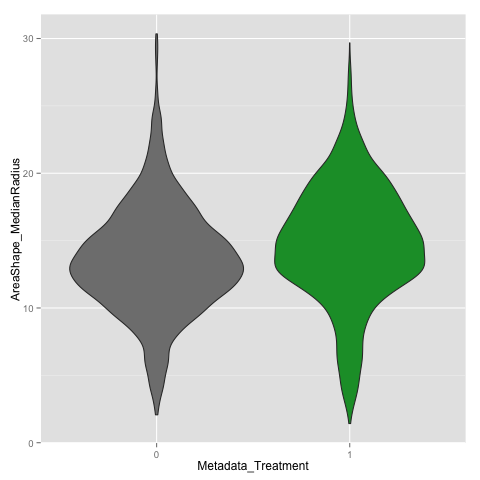

In [319]:
%%R
df_cont$Metadata_Treatment = as.factor(df_cont$Metadata_Treatment)

plot=ggplot()

#factor_order=c(800, 890, 875, 850)

plot = plot+geom_violin(data=df_cont,aes(x=Metadata_Treatment,y=AreaShape_MedianRadius,fill=factor(Metadata_Treatment)))
#plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))

#plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF') & (CSF_STG8$Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA<0.06),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA,fill=factor(Metadata_Type)))


#plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MedianIntensity_DNA,fill=factor(Metadata_Type)))
#plot=plot+scale_fill_manual(values=c('#E30D16','#815C5D','#9F4448', '#C6252B','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot+theme(legend.position='none')+scale_fill_manual(values=c('#7F7F7F','#179B33'))
#ggsave('../Plots/mixing_violin_Mean_FilteredChromatin_Intensity_MedianIntensity_DNA_5.pdf')

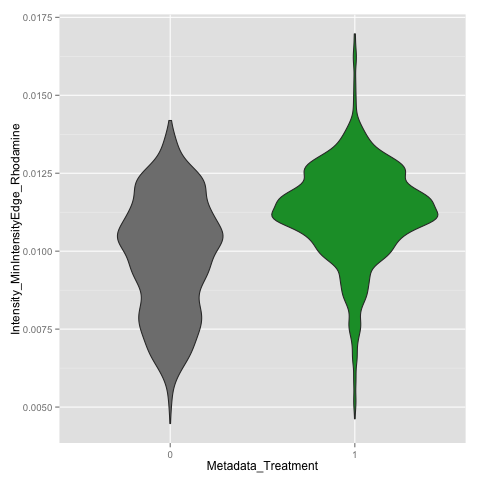

In [320]:
%%R
df_cont$Metadata_Treatment = as.factor(df_cont$Metadata_Treatment)

plot=ggplot()

#factor_order=c(800, 890, 875, 850)

plot = plot+geom_violin(data=df_cont,aes(x=Metadata_Treatment,y=Intensity_MinIntensityEdge_Rhodamine ,fill=factor(Metadata_Treatment)))
#plot = plot + scale_x_discrete("Metadata_Treatment", labels = c("800"="800","890"="890","875"="875","850"="850","CSF"="CSF"),limit=c("800", "890", "875", "850", "CSF"))

#plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF') & (CSF_STG8$Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA<0.06),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MaxIntensityEdge_DNA,fill=factor(Metadata_Type)))


#plot=plot+geom_violin(data=CSF_STG8[(CSF_STG8$Metadata_Type=='CSF'),], aes(x=factor(Metadata_Type),y=Mean_FilteredChromatin_Intensity_MedianIntensity_DNA,fill=factor(Metadata_Type)))
#plot=plot+scale_fill_manual(values=c('#E30D16','#815C5D','#9F4448', '#C6252B','#21AAA3'))
#class(df_mix$Metadata_Treatment)
plot+theme(legend.position='none')+scale_fill_manual(values=c('#7F7F7F','#179B33'))
#ggsave('../Plots/mixing_violin_Mean_FilteredChromatin_Intensity_MedianIntensity_DNA_5.pdf')

Edge variables are not the best (1-pixel wide).

####3. Using [KS](http://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm)      
Compares two continous distributions. 


In [321]:
%%R
print(dim(df_cont_no_Y_trans[Y_binary==0,]))
print(dim(df_cont_no_Y_trans[Y_binary==1,]))

#Math_AspectRatio

ks.test(df_cont_no_Y_trans[Y_binary==0,]$Math_AspectRatio, df_cont_no_Y_trans[Y_binary==1,]$Math_AspectRatio)[[2]]

[1] 1935  166
[1] 2621  166
[1] 0


In [322]:
%%R
test_KS = function(df){
    
    result=vector(mode='numeric', length = length(names(df)))
    
    for ( i in 1:length(names(df)) ) {

        #print(tryCatch(kruskal.test(Y_binary ~ df[,var], data = df)[[3]], error = print(var)))
        #print(try(kruskal.test(Y_binary ~ df[,var], data = df)[[3]], silent = TRUE))
        result[[i]]<-try( ks.test(df[Y_binary==0,i], df[Y_binary==1,i])[[2]] , silent = TRUE)
        #names(result[[i]]) = names(df)[i]
    }
    names(result) = names(df)
    return(result) 
}

In [323]:
%%R
result_KS = test_KS(df_cont_no_Y_trans)

In [324]:
%%R
print(class(result_KS))

#print(sort(result_KS)['Math_AspectRatio'])

sort(p.adjust(result_KS, method='bonferroni'))



[1] "numeric"
                                             AreaShape_Compactness 
                                                      0.000000e+00 
                                            AreaShape_Eccentricity 
                                                      0.000000e+00 
                                                  AreaShape_Extent 
                                                      0.000000e+00 
                                              AreaShape_FormFactor 
                                                      0.000000e+00 
                                         AreaShape_MajorAxisLength 
                                                      0.000000e+00 
                                        AreaShape_MaxFeretDiameter 
                                                      0.000000e+00 
                                           AreaShape_MaximumRadius 
                                                      0.000000e+00 
                                  

In [325]:
%%R

dim(as.data.frame(result_KS))
as.data.frame((sort(p.adjust(result_KS, method='bonferroni'))))

#write.csv(as.data.frame((sort(p.adjust(result_KS, method='bonferroni')))), "../Data/TPX2_features_KS_BONF_rank.csv")

                                                                   (sort(p.adjust(result_KS, method = "bonferroni")))
AreaShape_Compactness                                                                                    0.000000e+00
AreaShape_Eccentricity                                                                                   0.000000e+00
AreaShape_Extent                                                                                         0.000000e+00
AreaShape_FormFactor                                                                                     0.000000e+00
AreaShape_MajorAxisLength                                                                                0.000000e+00
AreaShape_MaxFeretDiameter                                                                               0.000000e+00
AreaShape_MaximumRadius                                                                                  0.000000e+00
AreaShape_MeanRadius                                    